In [148]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import datetime
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

In [295]:
data_orig= pd.read_csv("https://data.cityofnewyork.us/resource/erm2-nwe9.csv?$limit=999999999&$where=created_date%20between%20%272018-01-01T00:00:00.000%27%20and%20%272019-01-01T00:00:00.000%27")   



/Users/bwitte/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (8,17,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [296]:
type(data_orig.created_date)

pandas.core.series.Series

In [459]:
db = data_orig

In [460]:
#convert created and closed date columns to datetime, create new column called response time
db['created_date'] = pd.to_datetime(db['created_date'],errors = 'coerce')
db['closed_date'] = pd.to_datetime(db['closed_date'],errors = 'coerce')
db['response_time'] = db['closed_date'] - db['created_date']

In [461]:
#make all timedelta series into floats of total hours, remove all rows with NaN response_time
db['response_time_days'] = [i.total_seconds()/86400.0 for i in db['response_time']]
db['response_time_hours'] = [i.total_seconds()/3600.0 for i in db['response_time']]
db['response_time_minutes'] = [i.total_seconds()/60.0 for i in db['response_time']]
db['response_time_seconds'] = [i.total_seconds() for i in db['response_time']] 
db = db[db['response_time'].notnull()]

In [462]:
#create a new binary column reflecting whether a complaint took fewer than 2 minutes to resolve
def less_than(time):
    if time <= 120.0:
        return 1
    else:
        return 0

db['under_120'] = list(map(lambda x: less_than(x), db['response_time_seconds'])) 

/Users/bwitte/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [463]:
#remove rows without a resolution description, make all resolution descriptions lower
db['resolution_description']= db['resolution_description'].replace(np.nan, 'unknown', regex=True)
db['resolution_description'] = db['resolution_description'].str.lower()

/Users/bwitte/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/bwitte/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [464]:
#db[db.res_desc == "string"].groupby("resolution_description").count()

db[db.res_desc == "string"].resolution_description.value_counts()

AttributeError: 'DataFrame' object has no attribute 'res_desc'

In [465]:
#create a categorical column that provides a summarized description of the resolution description - used to group
#and analyze resolution descriptions

dno = ['did not observe', 'not able to gain access','could not find the problem', 'were gone','found no condition'\
      , 'no indication', 'no evidence', 'not find', 'unable to gain entry','no graffiti was found', 'could not locate',\
      'unable to find','attempted to investigate this complaint', "unable to identify", "you did not provide enough information",\
      "observed no evid", "inspected the location for the condition you reported and could not"]

no_action_taken = ['determined that no further action was necessary','condition meets its standards',\
                  'no sewer back up', 'at this time', 'no action', 'not necessary','had been restored',\
                  'found it to be a temporary','inspected the location more than six months ago',\
                  'conflicts with surrounding infrastructure','did not have enough information',\
                  'an inside condition','closed or canceled this complaint','insufficient information',\
                  'does not meet the criteria','no further action is required','did not have sufficient information',\
'no work order was necessary','did not meet the criteria','unable to schedule a sidewalk', 'no violation',\
                  'not have sufficient', 'ineligible', 'was cancelled', 'in compliance with standards', 'was in compliance',\
                  'not enough information', "is not a violation", "confirm the details of your complaint", "you are still responsible",\
                  "could not be serviced", "requested location cannot", "no work is nece", "does not violate any law or rule"]

under_review_wait = ['will review your complaint',' will contact you', 'asked the department of', 'further investigation is required',\
                    'timeframe for repair work depends','has been scheduled', 'will inspect', \
                    'will contact you','a report was prepared','complaint conditions are still open',\
                    'will perform work to correct the condition','has sent official written','please check back later for status',\
                    'and will visit the location','will investigate the issue','usually requires 7 days to inspect',\
                    'usually requires 30 days to inspect','referred this complaint','a location of concern',
                    'your report has been sent','has received and processed your complaint','the literature will be emailed',\
                    'will review this service request','in the process of investigating','scheduled an inspection',\
                    'garage or bureau for further action','will investigate the issue','approved the sidewalk re-inspection request',\
'usually requires 10 days to review a request','will clean the graffiti','has been forwarded',\
'please note your service request number for future reference','requires contact with the complainant','will be notified',\
'will investigate','will fulfill','will receive','an inspection is warranted','to respond to this type of complaint',\
'to evaluate this type of request','opened a repair order','will be planned','long term and vary','will  investigate', \
                     'temporarily', 'partially rectified', 'will review','will notify','has been filed', \
                     'further investigation','will note','under investigation','mailed you a complaint form', "requires you to attend a hearing",\
                    "please submit the following document", "will be scheduled", "will take place within 35 days", "the timeframe for repair",\
                    'they needed to confirm']

violations = ['violations were issued', 'board violation', 'notice of violation','stop work order violation(s) issued', 'violation was issued']

fixed = ['repaired the problem','department of sanitation removed the items','corrected the','correct the', 'repaired',\
         'cleaned', 'addressed the issue','provided the assistance','removed the graffiti','will be addressed',\
         'offered services', 'conditions were corrected','shut the running hydrant', 'were corrected', 'you will receive',\
        'collected', 'resolved', 'researched this complaint', 'took action','issued a','the problem was fixed',\
        'work was performed','removed the stop work order','the literature has been mailed',\
        'complaint was not warranted','performed repair work','made a repair','outreach assistance was offered',\
'opened fire hydrants','picked up the items','if the condition returns','salted the area','updated its records',\
'to a hospital','has been completed', 'was addressed','owner refused', 'debris was obstructing', 'was mailed','have mailed',\
        'was placed','created a service request','created a service request','mailed the requested item',\
         'investigated this complaint and','sent a report', "pled guilty", "a hearing was scheduled", "temporary repairs were made",\
        "has planted the tree", "the letter was returned as undeliverable", "plowed the area.", "made an arrest", "a summons has been issued"]

ambiguous = ['see notes', 'find additional information', 'learn more','more information', \
             'researched your claim','asked the department',\
            'has notified the property owner','additional information below', 'violations were previously issued',\
             'currently not available','unknown', "the department of buildings reviewed this complaint and closed it. if the problem still exists,",\
            "a defect was found done", "surcharge conditions have been confirmed",\
             "the department of transportation inspected the condition you reported. you can find additional infor",\
            "reviewed this complaint and closed it. if the problem still exists", "and found that the condition m",\
            "a representative from the taxi and limousine commission (tlc) called and left a message for you and",\
            "due to technical issues or other circumstances", "inspected the condition and made the determination that the street",\
            "inspected the condition you reported and determined that this issue"]

wrong_agency = ['jurisdiction', 'referred it','referred it to', "has referred this request",\
                "handling by an alternate entity", "the department of transportation inspected and has requested the department of environmental protect"]

dup = ['duplicate','previously reported by another','an open service request already exists', 'received an earlier complaint about the same location']

def string_replace(string):
    if string == 'unknown':
        return string
    elif any(x in string for x in no_action_taken):
        return 'no_action_taken'
    elif any(x in string for x in under_review_wait):
        return 'ongoing'
    elif any(x in string for x in dno):
        return 'did_not_observe'
    elif any(x in string for x in violations):
        return 'violations_issued'
    elif any(x in string for x in fixed):
        return 'fixed'
    elif any(x in string for x in wrong_agency):
        return 'wrong_agency'
    elif any(x in string for x in dup):
        return 'duplicate'
    elif any(x in string for x in ambiguous):
        return 'ambiguous'
    else:
        return 'string'

db['res_desc'] = [string_replace(x) for x in db['resolution_description']]

/Users/bwitte/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [466]:
#to see only complaint types with more than 1,500 complains
from collections import Counter
res_desc_lists = Counter(db['res_desc'])
res_desc_list=[]
for res, count in res_desc_lists.items():   
    if count > 1500:
        res_desc_list.append(res)
db_filtered = db[db['res_desc'].isin(res_desc_list)]
db_filtered = db[db['response_time_seconds']>120]

In [467]:
#aggregate by agency and complaint type to see long complaints
grouped_complaints = db_filtered.groupby(['agency','complaint_type'])
time_per_complain_type = grouped_complaints['response_time_days'].agg(['mean', 'std','count'])
time_per_complain_type= time_per_complain_type.reset_index()
time_per_complain_type_long = time_per_complain_type[
    (time_per_complain_type['mean']>=31)&(time_per_complain_type['count']>1000)].sort_values(by='mean', ascending=False).reset_index()
time_per_complain_type_long.to_csv('longest_complaint_times.csv')

In [468]:
# understand res_desc for each complaint type
agg = db_filtered.groupby(['agency','complaint_type','res_desc'])
aggregated_complaint_times = agg['response_time_hours'].agg(
    ['count','mean','std']).sort_values(by=['agency','complaint_type','count'], ascending=False)
aggregated_complaint_times['mean_days'] = list(map(lambda x: round(x/24,2), aggregated_complaint_times['mean']))
aggregated_complaint_times['std'] = list(map(lambda x: round(x/24,2), aggregated_complaint_times['std']))
aggregated_complaint_times_formatted = aggregated_complaint_times.reset_index()
aggregated_complaint_times_formatted.to_csv('2017_agg_complaint_times_data.csv', sep = ',')

In [469]:
#understanding what percentage of total for each res_desc


outcome_rates = {'other': round(len(db[db['res_desc']=='string'])/len(db),3),\
'duplicate': round(len(db[db['res_desc']=='duplicate'])/len(db),3),\
'fixed':round(len(db[db['res_desc']=='fixed'])/len(db),3),\
'did_not_observe':round(len(db[db['res_desc']=='did_not_observe'])/len(db),3),\
'no_action_taken':round(len(db[db['res_desc']=='no_action_taken'])/len(db),3),\
'violations_issued':round(len(db[db['res_desc']=='violations_issued'])/len(db),3),\
'ambiguous':round(len(db[db['res_desc']=='ambiguous'])/len(db),3),\
'ongoing':round(len(db[db['res_desc']=='ongoing'])/len(db),3),\
'wrong_agency':round(len(db[db['res_desc']=='wrong_agency'])/len(db),3),\
'fixed_or_violations_issued':round(len(db[db['res_desc']=='violations_issued']+db[db['res_desc']=='fixed'])/len(db),2),\
'did_not_observe_or_no_action_taken':round(len(db[db['res_desc']=='no_action_taken']+db[db['res_desc']=='did_not_observe'])/len(db),2)}


print(outcome_rates)

{'other': 0.002, 'duplicate': 0.052, 'fixed': 0.229, 'did_not_observe': 0.244, 'no_action_taken': 0.195, 'violations_issued': 0.042, 'ambiguous': 0.104, 'ongoing': 0.053, 'wrong_agency': 0.009, 'fixed_or_violations_issued': 0.27, 'did_not_observe_or_no_action_taken': 0.44}


In [470]:
#db['res_desc'==string]
db.res_desc.value_counts().rename_axis('categories').reset_index(name='counts').to_csv('2018_categorization_counts.csv')

In [471]:
#creating df that shows response time by agency
resp_by_agency = db_filtered.groupby('agency')['response_time_hours'].agg('mean').to_frame()
resp_by_agency = resp_by_agency.sort_values(by = 'response_time_hours', ascending=False).reset_index()#resp_by_agency.to_csv('2018_11_05_response_time_by_agency_2017_data.csv')

In [472]:
#shows breakdown of agency performance by borough
agency_list = ['NYPD','HPD','DOT','DSNY','DEP','DPR','DOB','DOF','DOHMH','DHS','TLC']
boards_complaint = db_filtered.groupby(['community_board','agency'])
board_agg = boards_complaint['response_time_hours'].agg(['count','mean','std']).sort_values(by = ['community_board','agency','mean','count'])
board_agg = board_agg[board_agg['count']>100]
boards_agg_df = board_agg.reset_index()
boards_agg_df = boards_agg_df.query('agency in @agency_list')
boards_agg_df = boards_agg_df[boards_agg_df['community_board'].str.contains('Unspecified') ==False]
boards_agg_df= boards_agg_df.sort_values(by= 'community_board')

In [473]:
def join(string):
    string = string.split(' ')
    return string[1]+' '+string[0]

boards_agg_df['community_board'] = list(map(lambda x: join(x), boards_agg_df['community_board'])) 

In [474]:
agency_name_list = ['NYPD','HPD','DOT','DSNY','DEP','DPR','DOB','DOF','DOHMH','DHS','TLC']
boards_agg_df['mean'] = boards_agg_df['mean'].apply(np.log)


nypd = boards_agg_df[boards_agg_df['agency']=='NYPD'].sort_values(by='community_board')
hpd = boards_agg_df[boards_agg_df['agency']=='HPD'].sort_values(by='community_board')
dot = boards_agg_df[boards_agg_df['agency']=='DOT'].sort_values(by='community_board')
dsny = boards_agg_df[boards_agg_df['agency']=='DSNY'].sort_values(by='community_board')
dep = boards_agg_df[boards_agg_df['agency']=='DEP'].sort_values(by='community_board')
dpr = boards_agg_df[boards_agg_df['agency']=='DPR'].sort_values(by='community_board')
dob = boards_agg_df[boards_agg_df['agency']=='DOB'].sort_values(by='community_board')
dof = boards_agg_df[boards_agg_df['agency']=='DOF'].sort_values(by='community_board')
dohmh = boards_agg_df[boards_agg_df['agency']=='DOHMH'].sort_values(by='community_board')
dhs = boards_agg_df[boards_agg_df['agency']=='DHS'].sort_values(by='community_board')
tlc = boards_agg_df[boards_agg_df['agency']=='TLC'].sort_values(by='community_board')

agency_list = [nypd,hpd,dot,dsny,dep,dpr,dob,dof,dohmh,dhs,tlc]

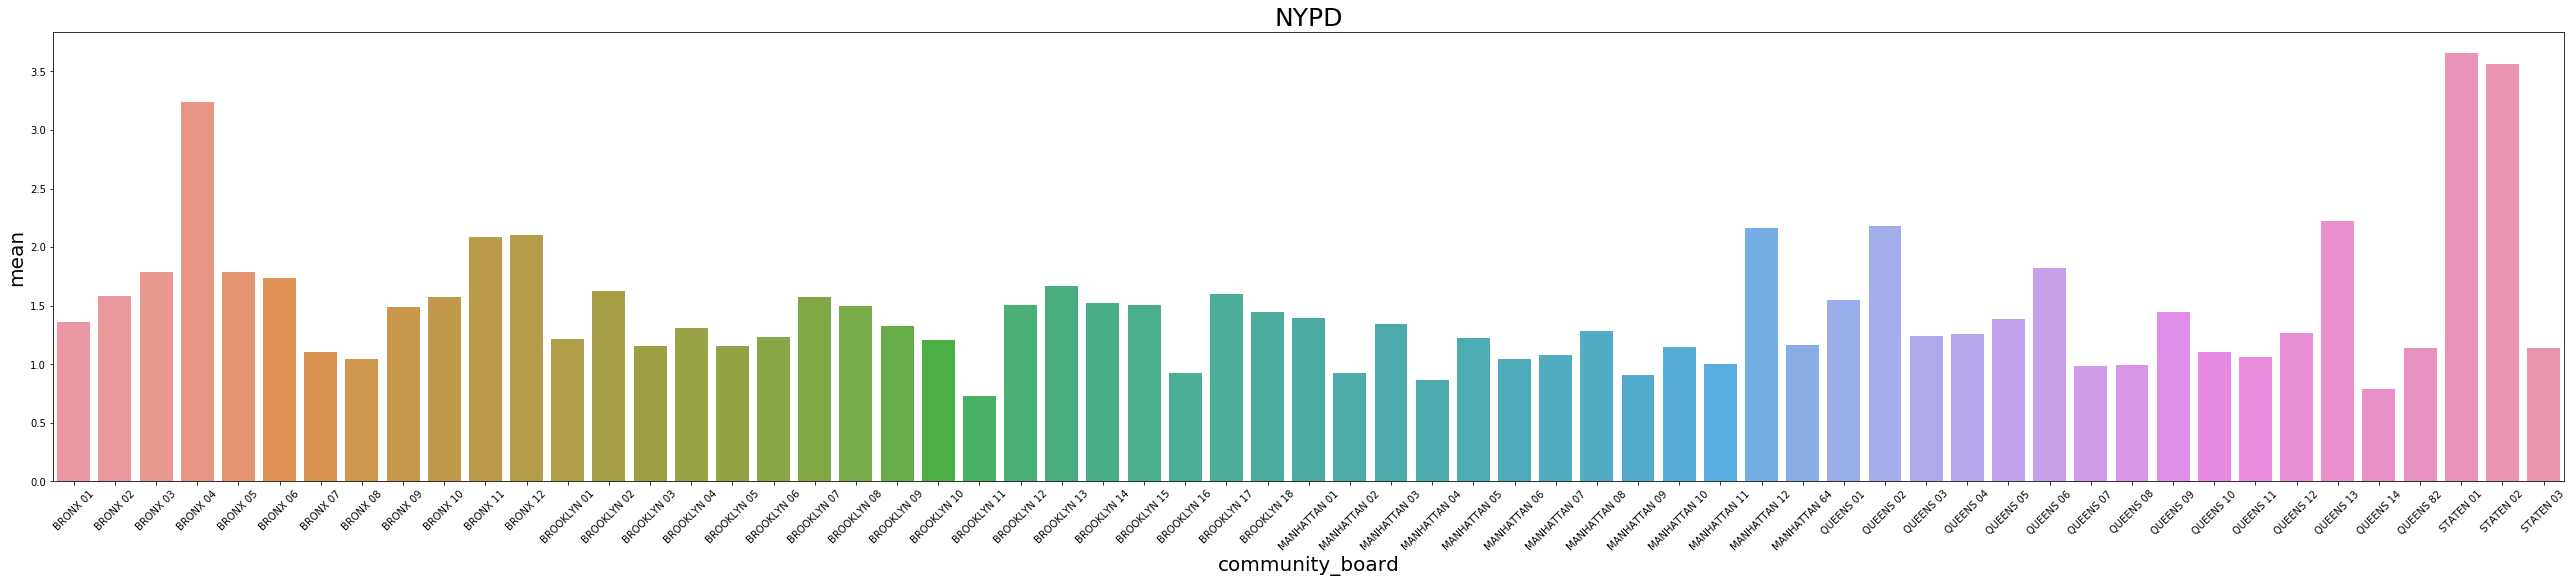

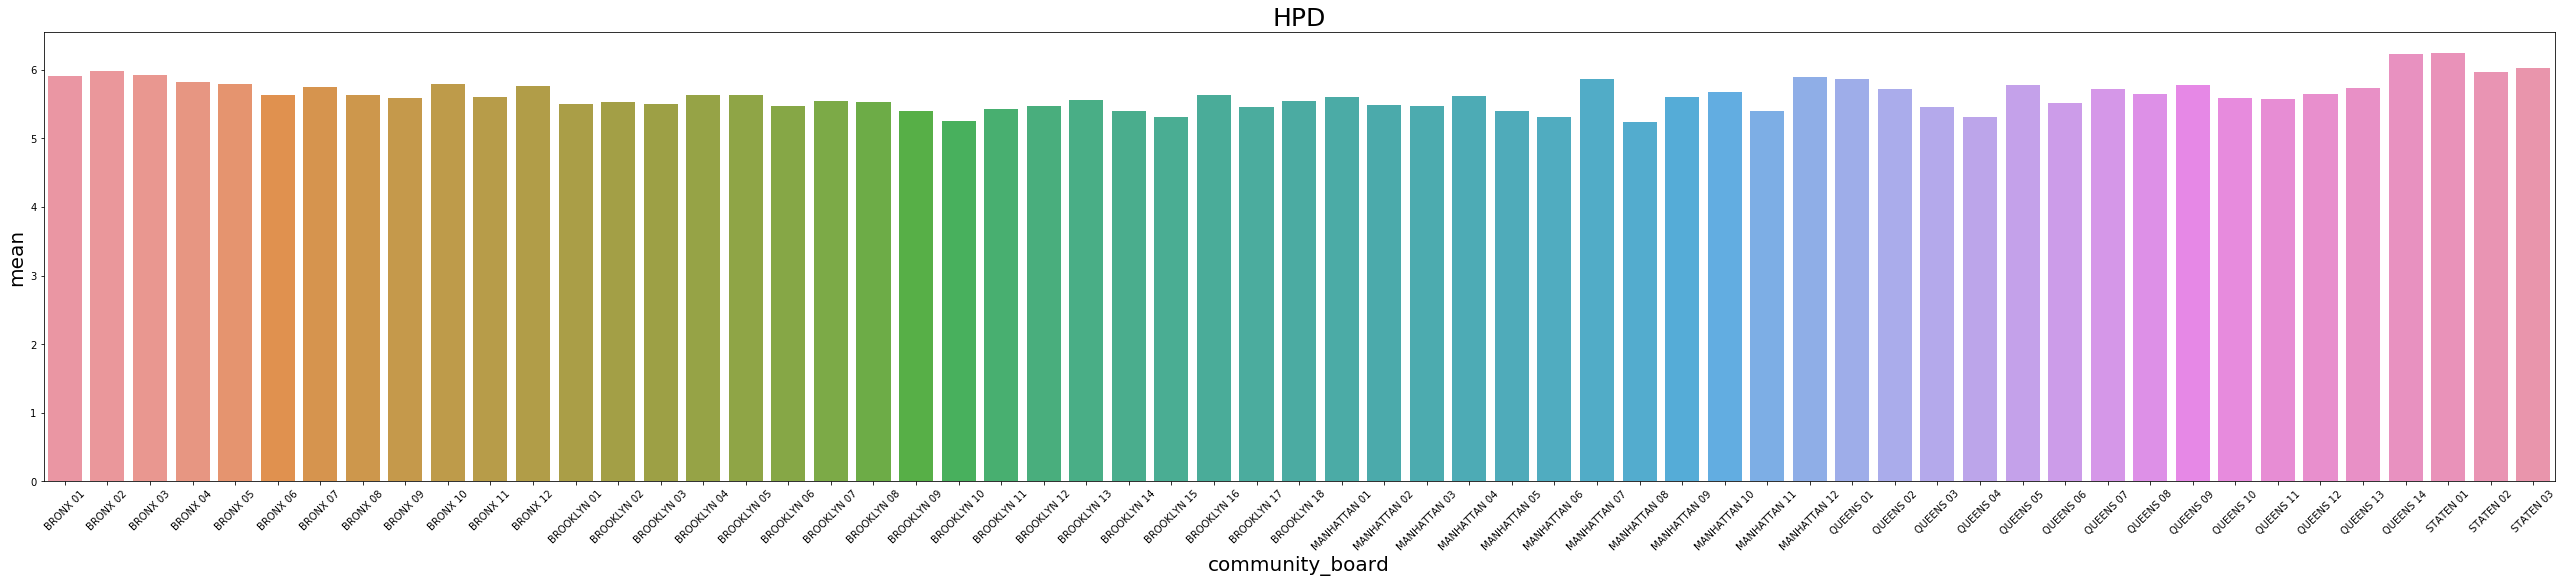

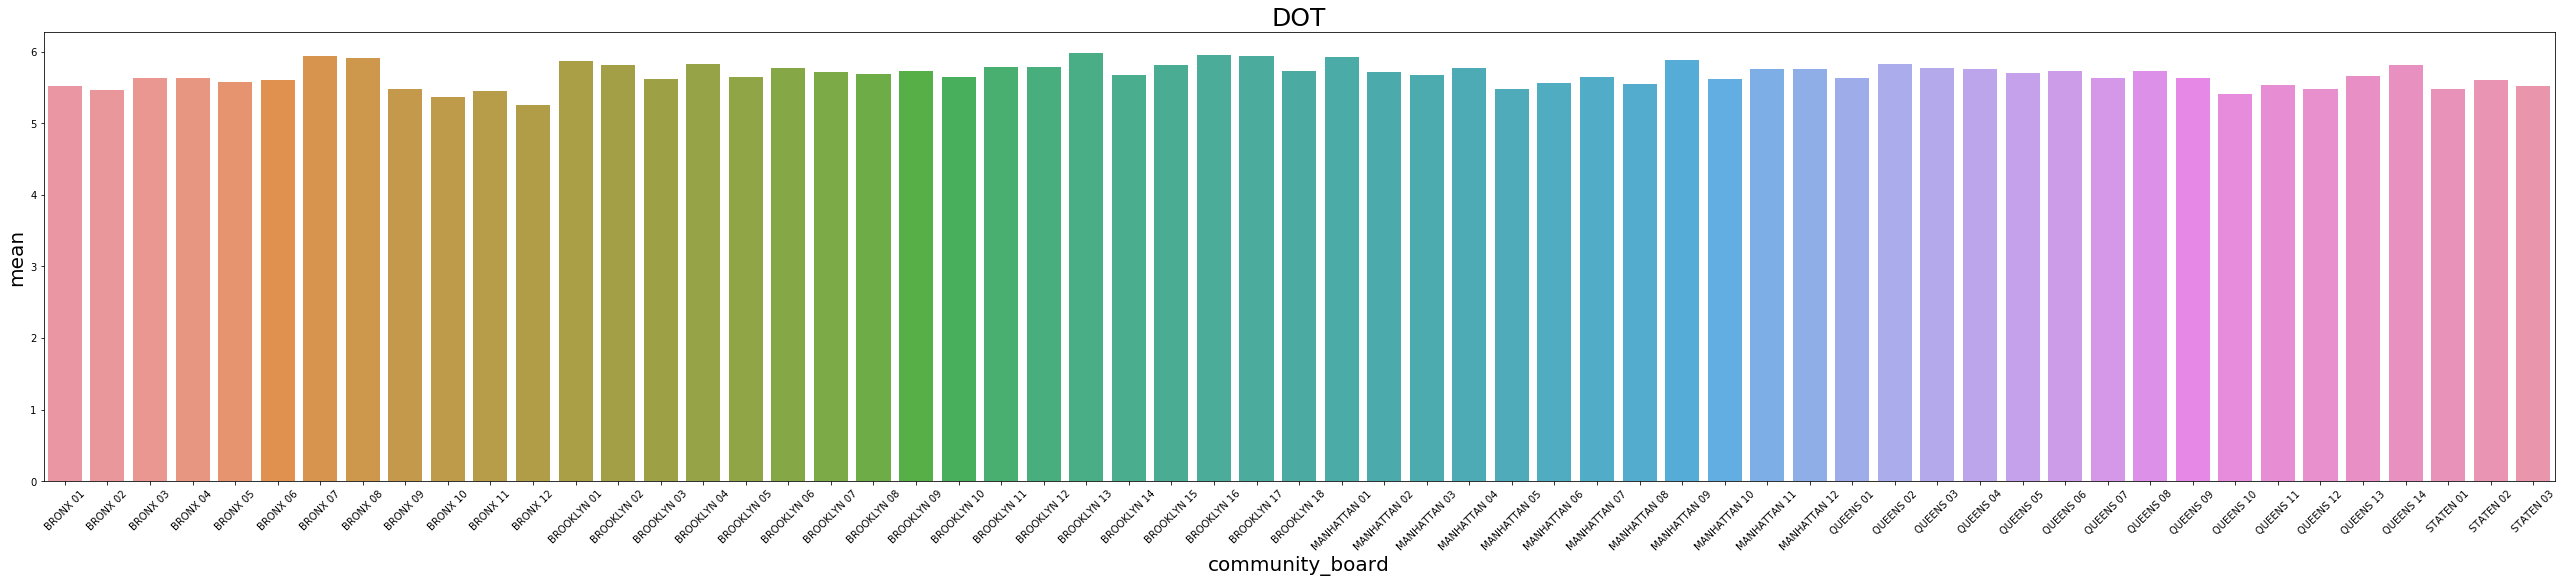

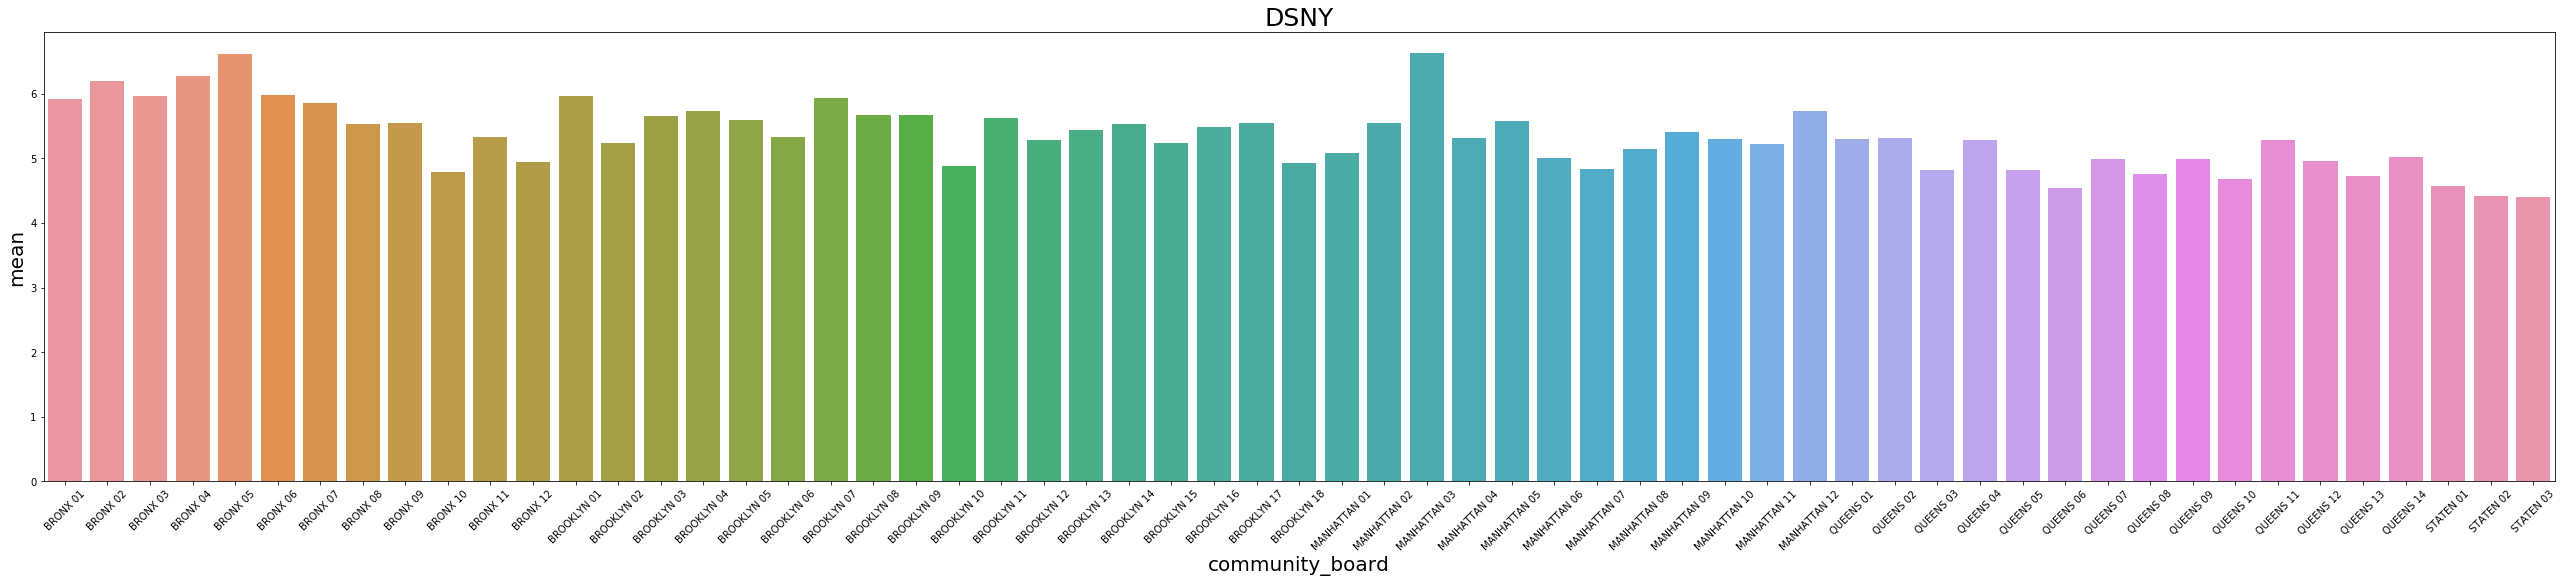

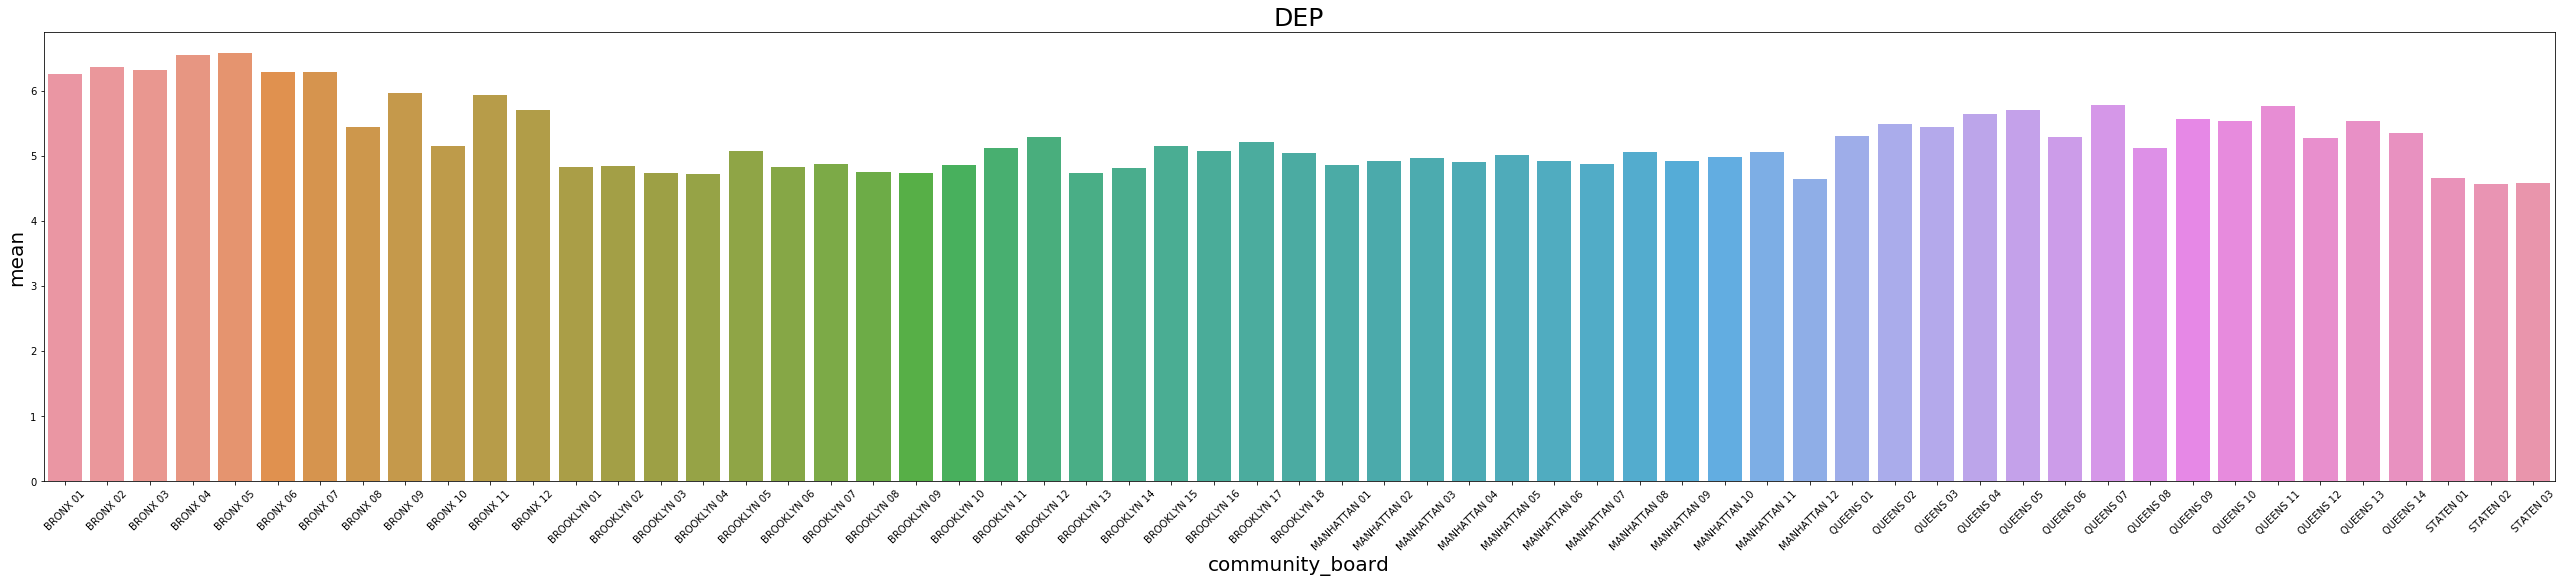

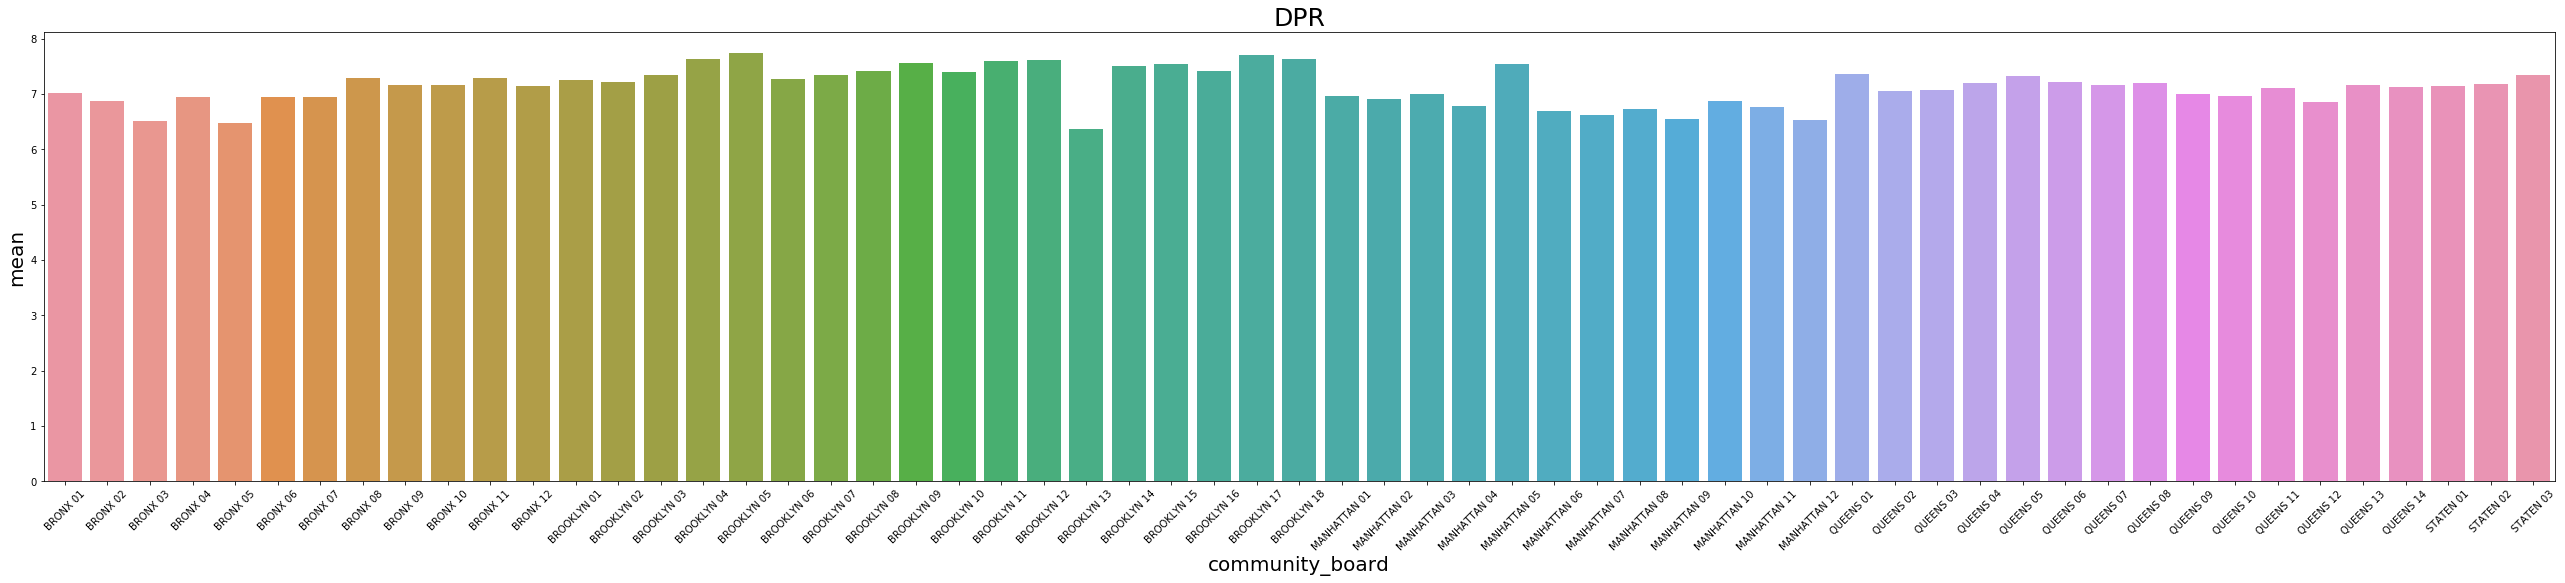

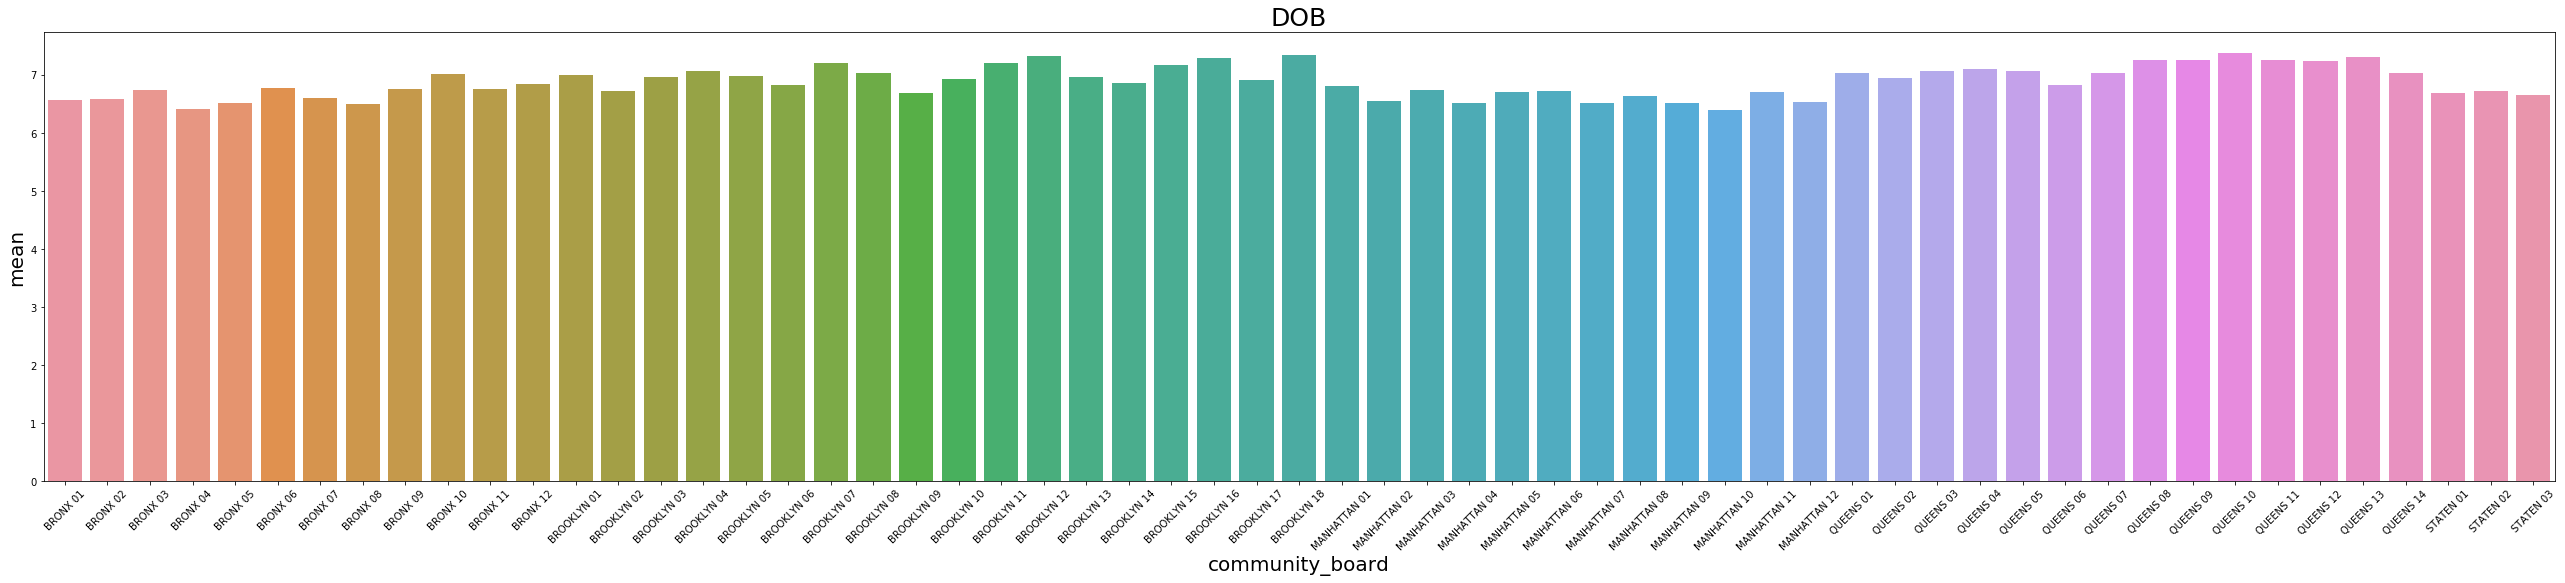

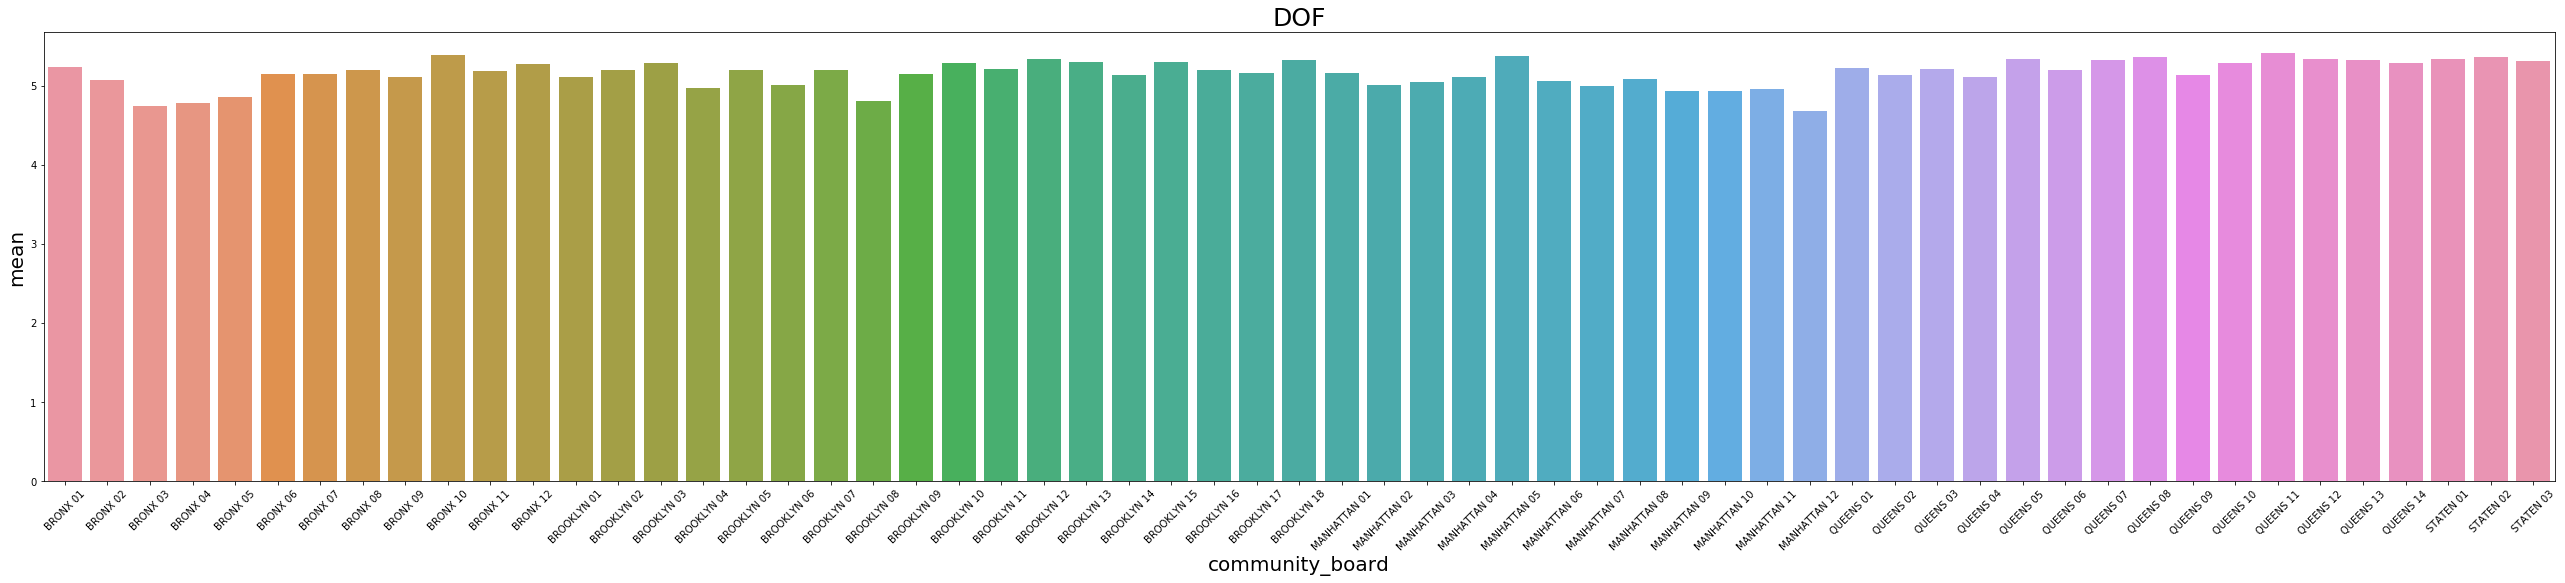

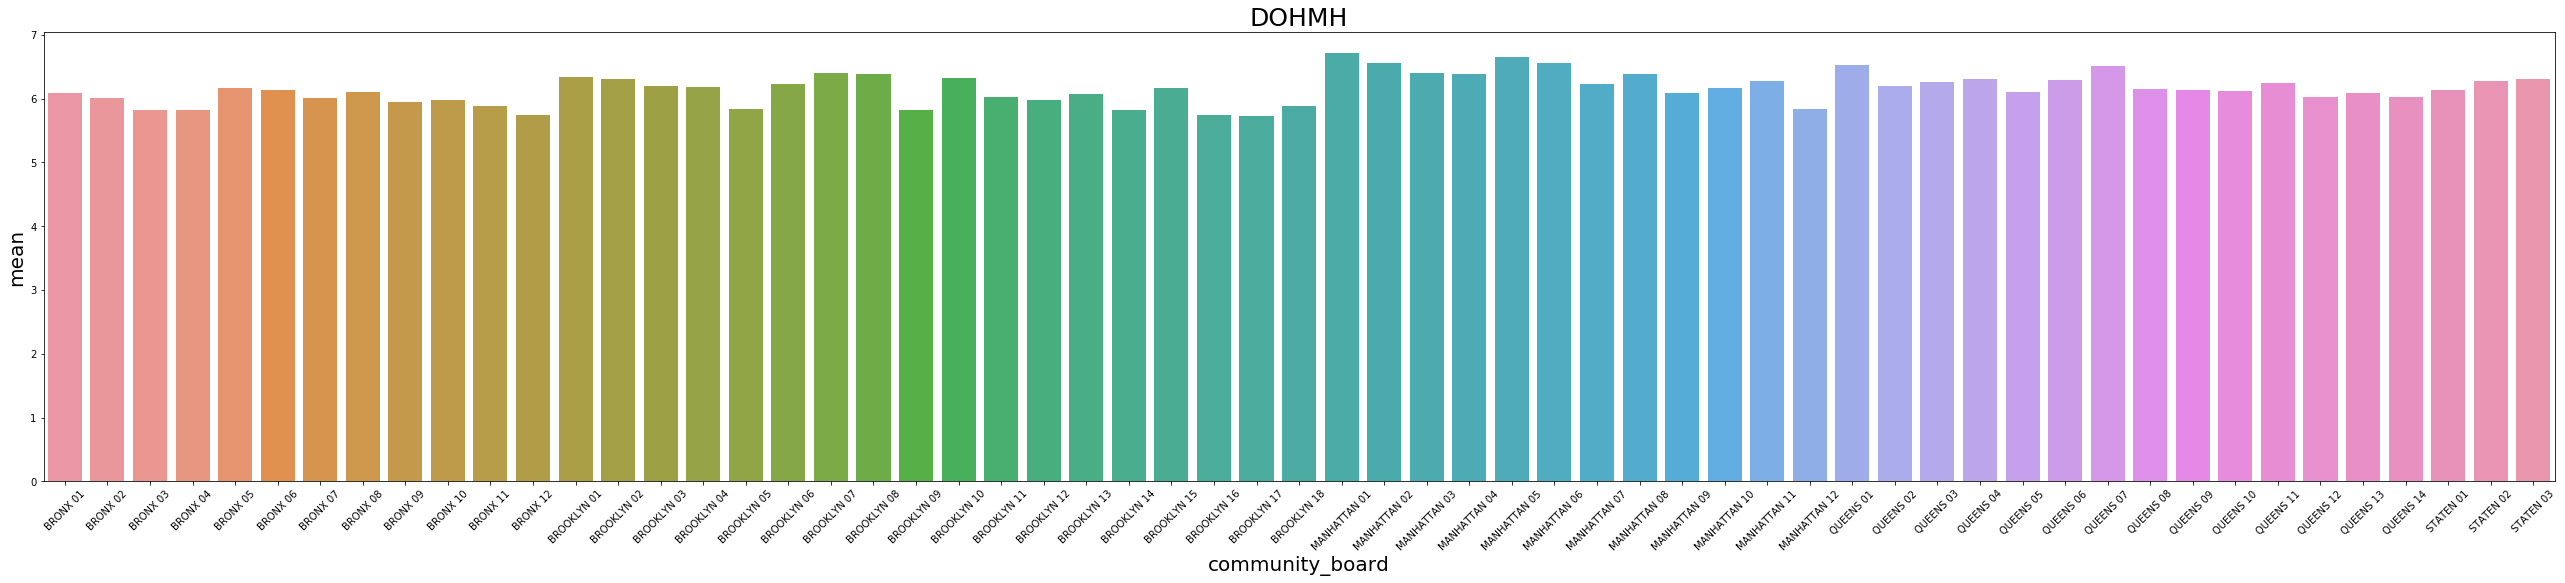

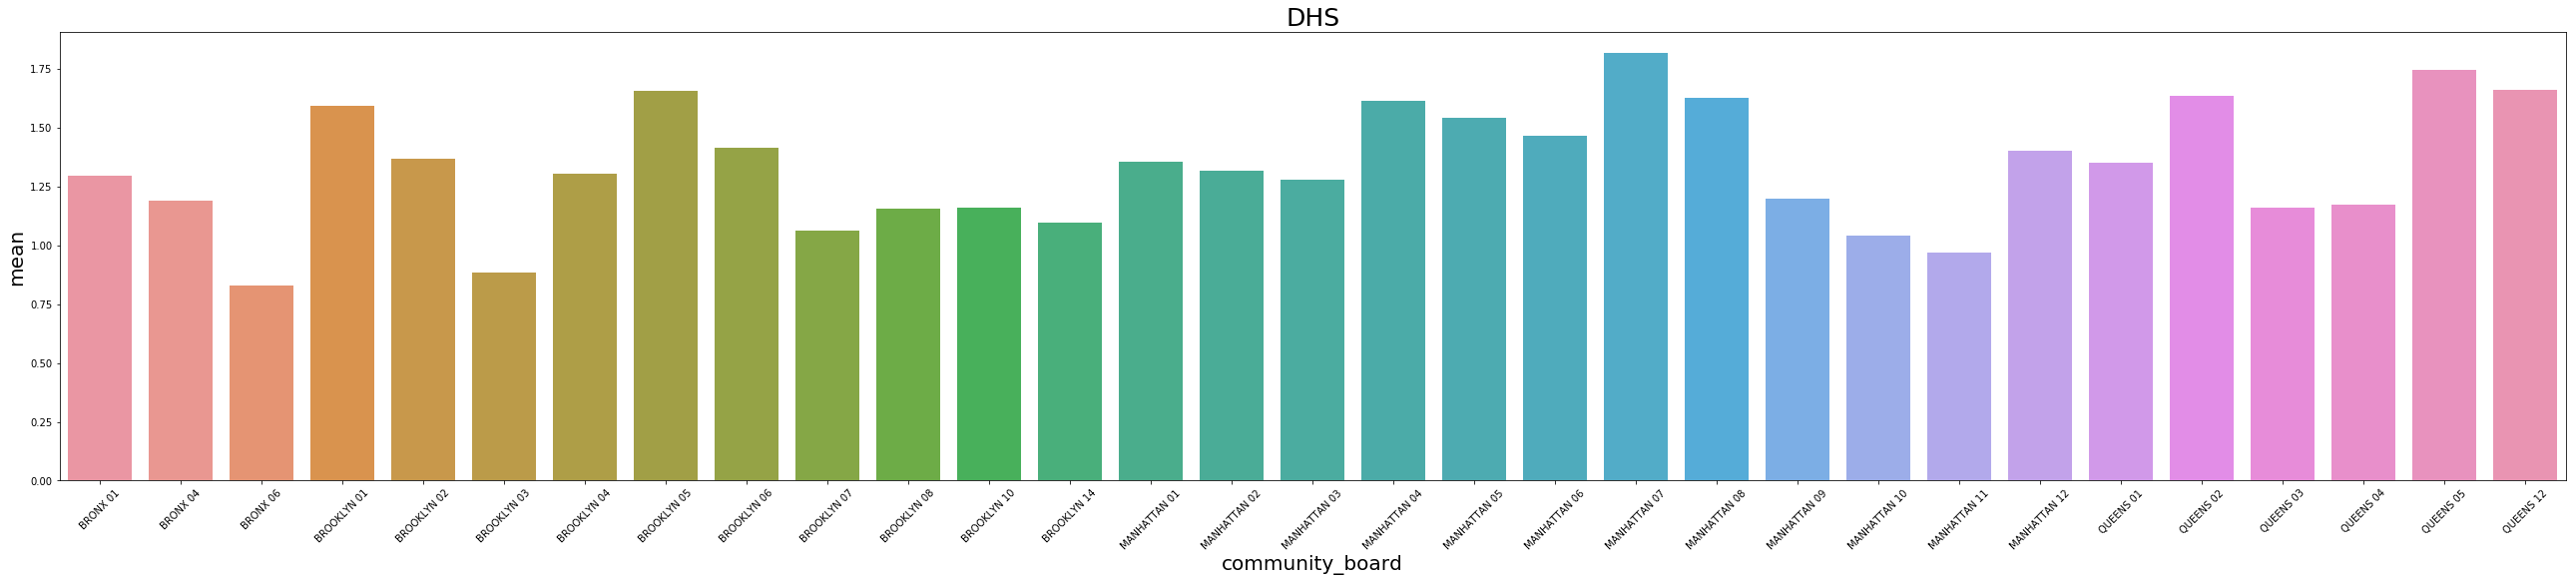

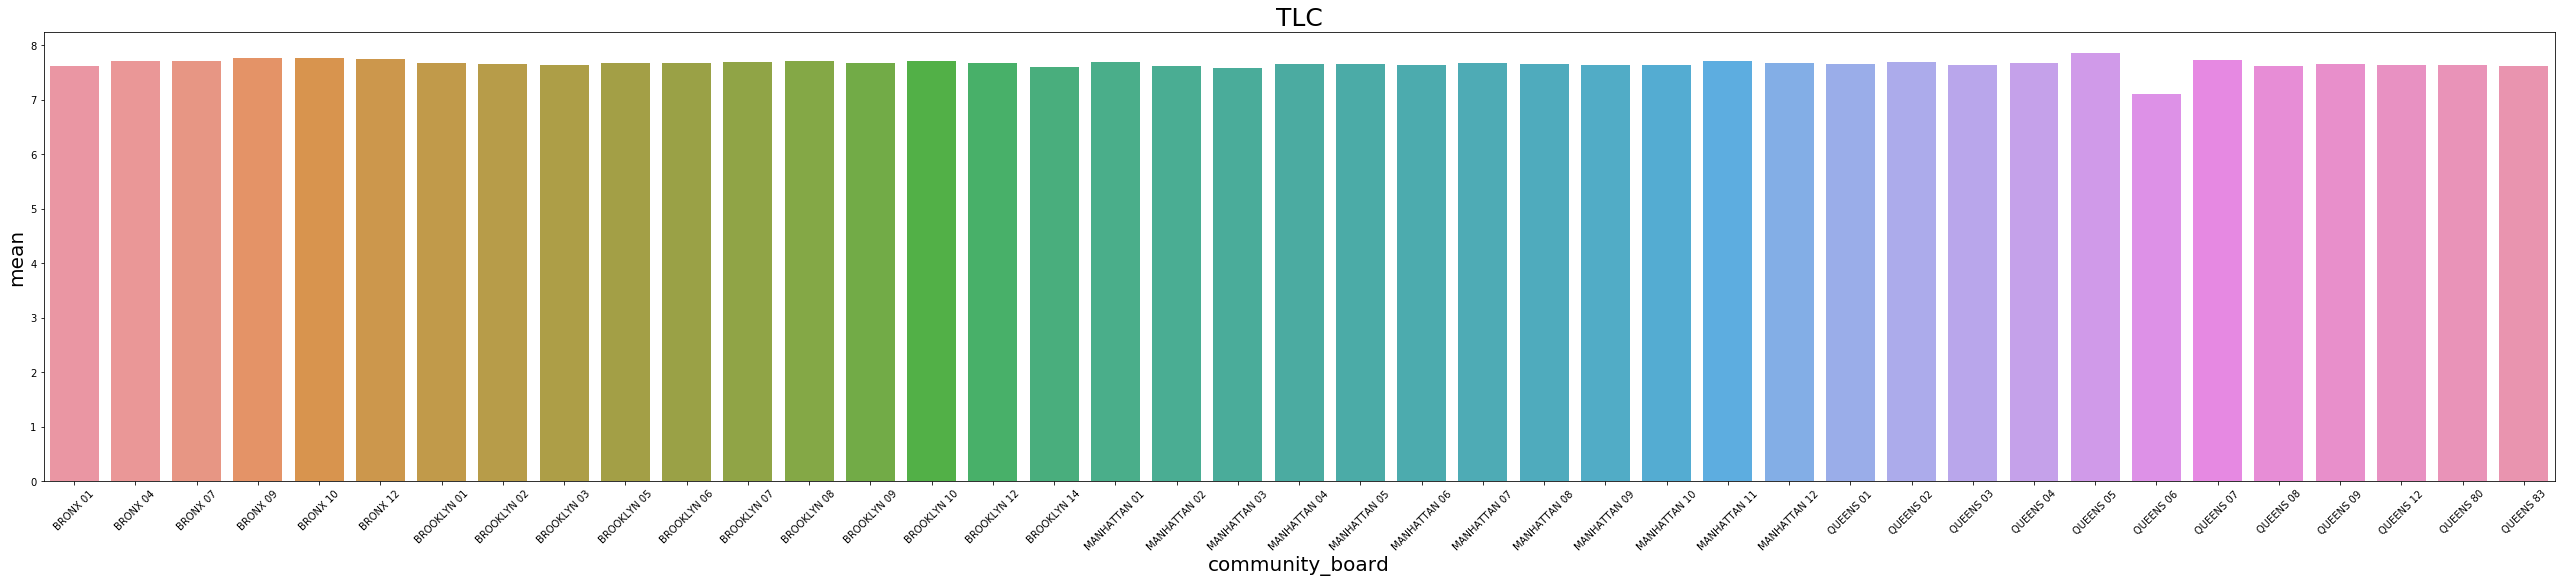

In [475]:
#visually breaks down agency performance by board
x= 'community_board'
y= 'mean'
a4_dims = (45, 8.27)

for i in range(len(agency_list)):
    fig, ax = plt.subplots(figsize=a4_dims)
    ax.set_title(agency_name_list[i], fontsize=25)
    ax.set_xlabel("community_board",fontsize=20)
    ax.set_ylabel("Mean Completion Time",fontsize=20)
    agencyboardplot = sns.barplot(x, y, data=agency_list[i], ax=ax)
    agencyboardplot.set_xticklabels(agencyboardplot.get_xticklabels(), rotation=45)


In [476]:
#looking at community board breakdown by complaint type so that we can take a closer look at what might be going on with NYPD Response times
boards_complaint_type = db_filtered.groupby(['community_board','agency','complaint_type'])
board_comp_agg = boards_complaint_type['response_time_hours'].agg(['count','mean','std']).sort_values(by = ['community_board','agency','complaint_type','mean','count'])
board_comp_agg = board_comp_agg[board_comp_agg['count']>100]
boards_comp_agg_df = board_comp_agg.reset_index()
boards_comp_agg_df = boards_comp_agg_df[boards_comp_agg_df['community_board'].str.contains('Unspecified') ==False]
boards_comp_agg_df= boards_comp_agg_df.sort_values(by= 'community_board')
boards_comp_agg_df['mean'] = boards_comp_agg_df['mean'].apply(np.log)
boards_comp_agg_df['community_board'] = list(map(lambda x: join(x), boards_comp_agg_df['community_board'])) 



In [477]:
nypd_comps = boards_comp_agg_df[boards_comp_agg_df['agency']=='NYPD'].sort_values(by='community_board')

In [478]:
illegal_parking = nypd_comps[nypd_comps['complaint_type']=='Illegal Parking'].sort_values(by='community_board')

noise_street_sidewalk = nypd_comps[nypd_comps['complaint_type']=='Noise - Street/Sidewalk'].sort_values(by='community_board')

noise_residential = nypd_comps[nypd_comps['complaint_type']=='Noise - Residential'].sort_values(by='community_board')

blocked_driveway = nypd_comps[nypd_comps['complaint_type']=='Blocked Driveway'].sort_values(by='community_board')

noise_vehicle = nypd_comps[nypd_comps['complaint_type']=='Noise - Vehicle'].sort_values(by='community_board')

noise_commercial = nypd_comps[nypd_comps['complaint_type']=='Noise - Commercial'].sort_values(by='community_board')

animal_abuse = nypd_comps[nypd_comps['complaint_type']=='Animal Abuse'].sort_values(by='community_board')

derelict_vehicle = nypd_comps[nypd_comps['complaint_type']=='Derelict Vehicle'].sort_values(by='community_board')

non_emergency_police_matter = nypd_comps[nypd_comps['complaint_type']=='Non-Emergency Police Matter'].sort_values(by='community_board')

noise_park = nypd_comps[nypd_comps['complaint_type']=='Noise - Park'].sort_values(by='community_board')

traffic = nypd_comps[nypd_comps['complaint_type']=='Traffic'].sort_values(by='community_board')

homeless_encampment = nypd_comps[nypd_comps['complaint_type']=='Homeless Encampment'].sort_values(by='community_board')

vending = nypd_comps[nypd_comps['complaint_type']=='Vending'].sort_values(by='community_board')

nypd_complaint_list = ['illegal_parking','noise_street_sidewalk','noise_residential','blocked_driveway','noise_vehicle',
                      'noise_commercial','animal_abuse','derelict_vehicle','non_emergency_police_matter','noise_park',
                      'traffic','homeless_encampment','vending']

nypd_complaints = [illegal_parking,noise_street_sidewalk,noise_residential,blocked_driveway,noise_vehicle,
                      noise_commercial,animal_abuse,derelict_vehicle,non_emergency_police_matter,noise_park,
                      traffic,homeless_encampment,vending]

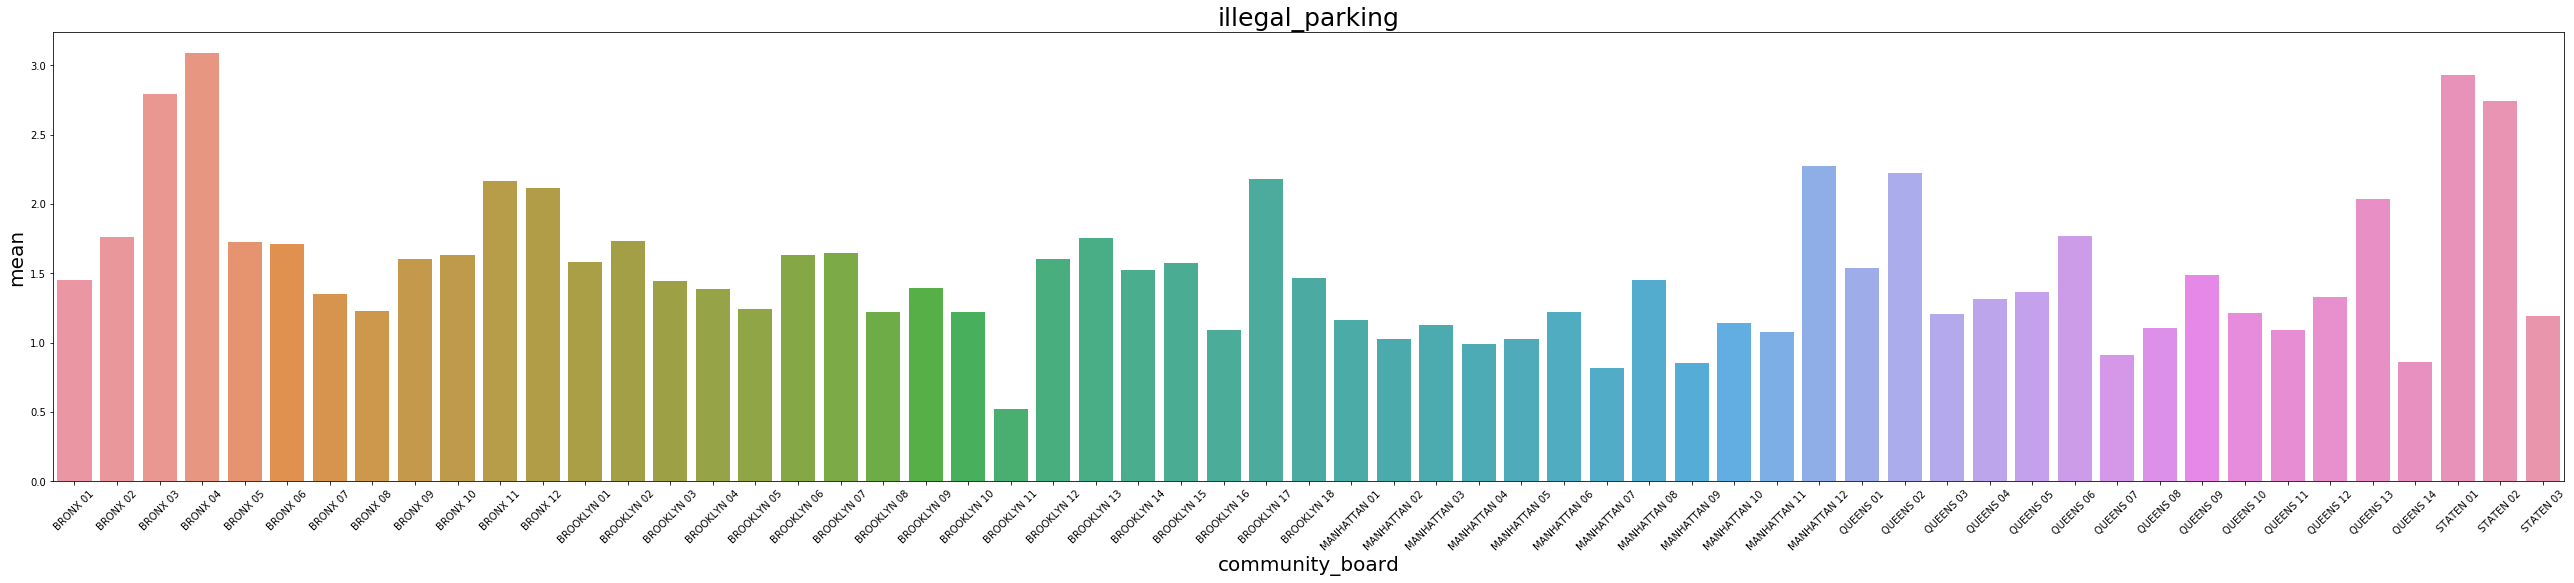

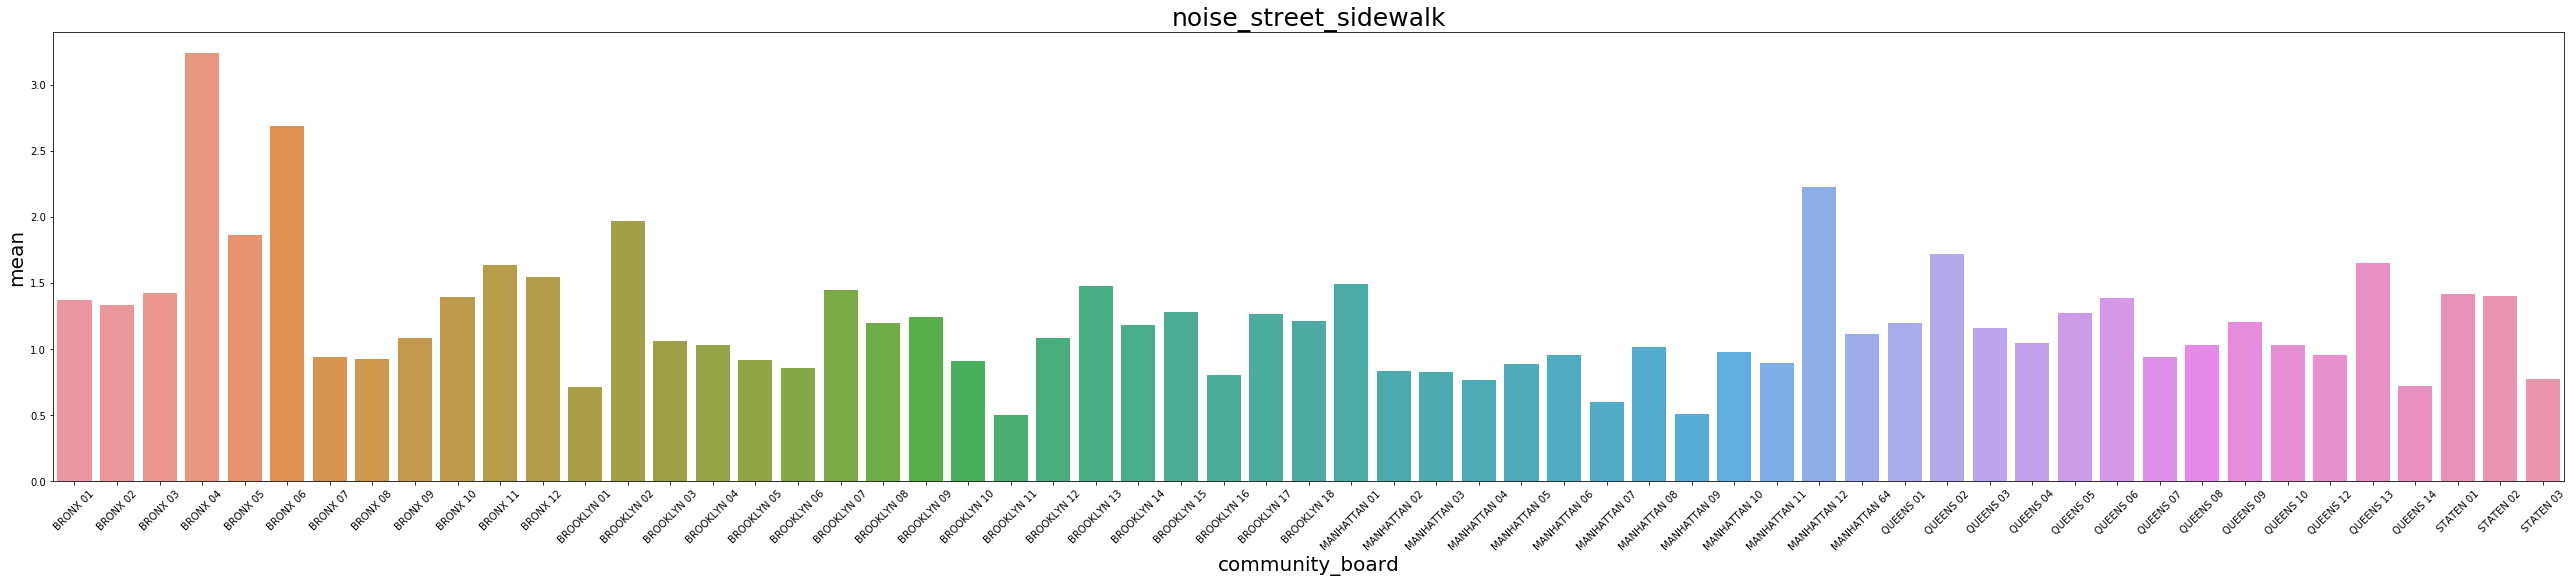

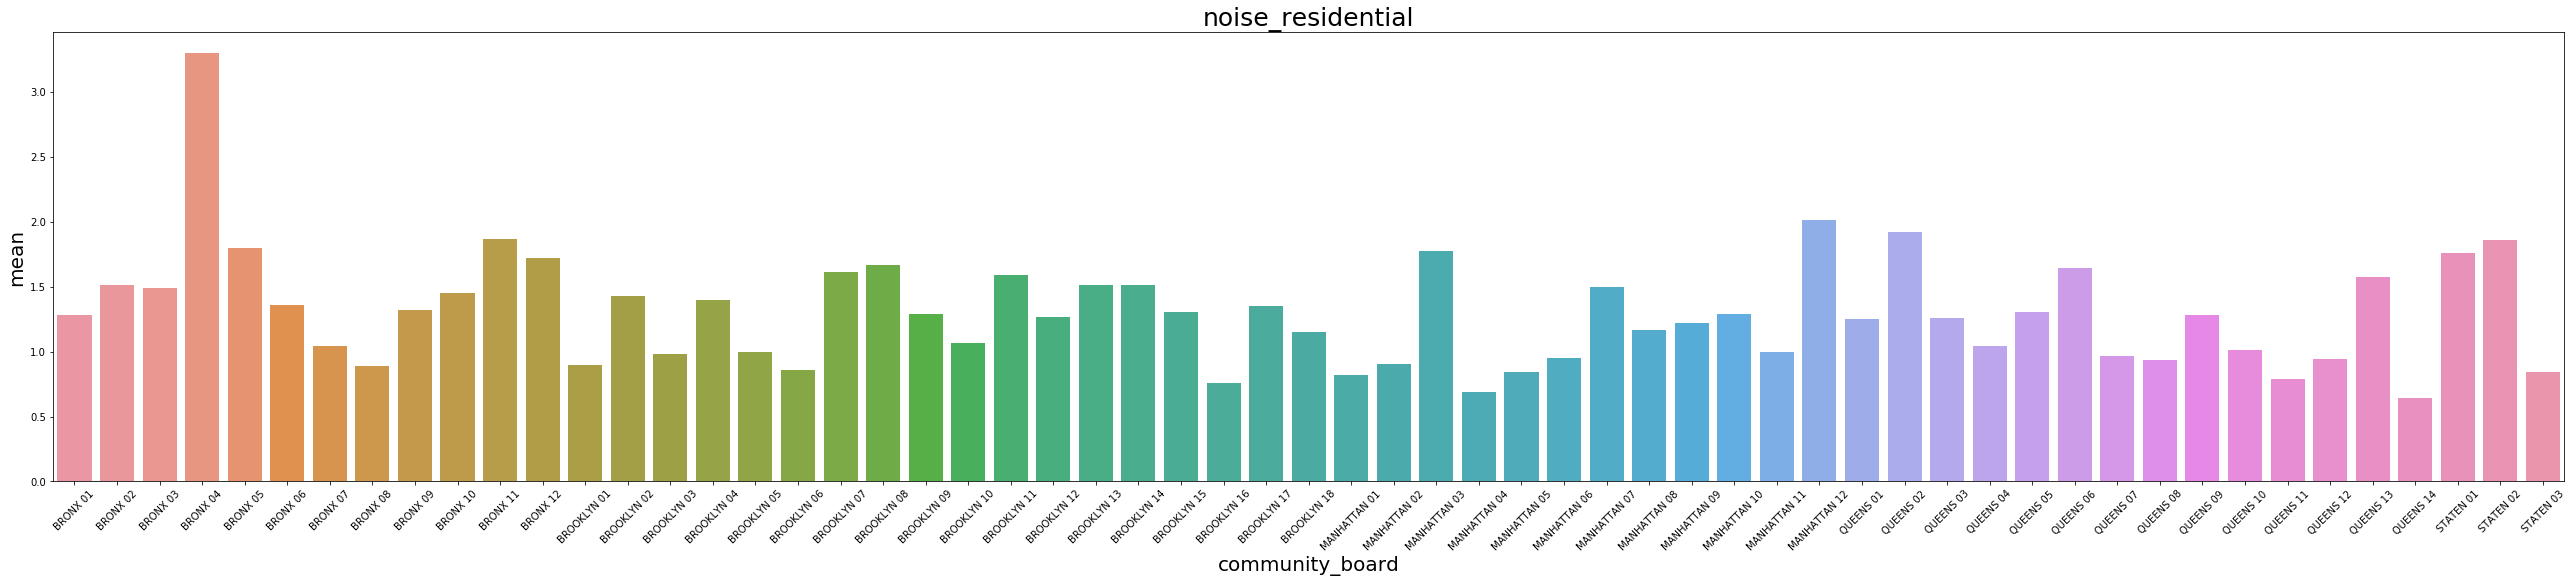

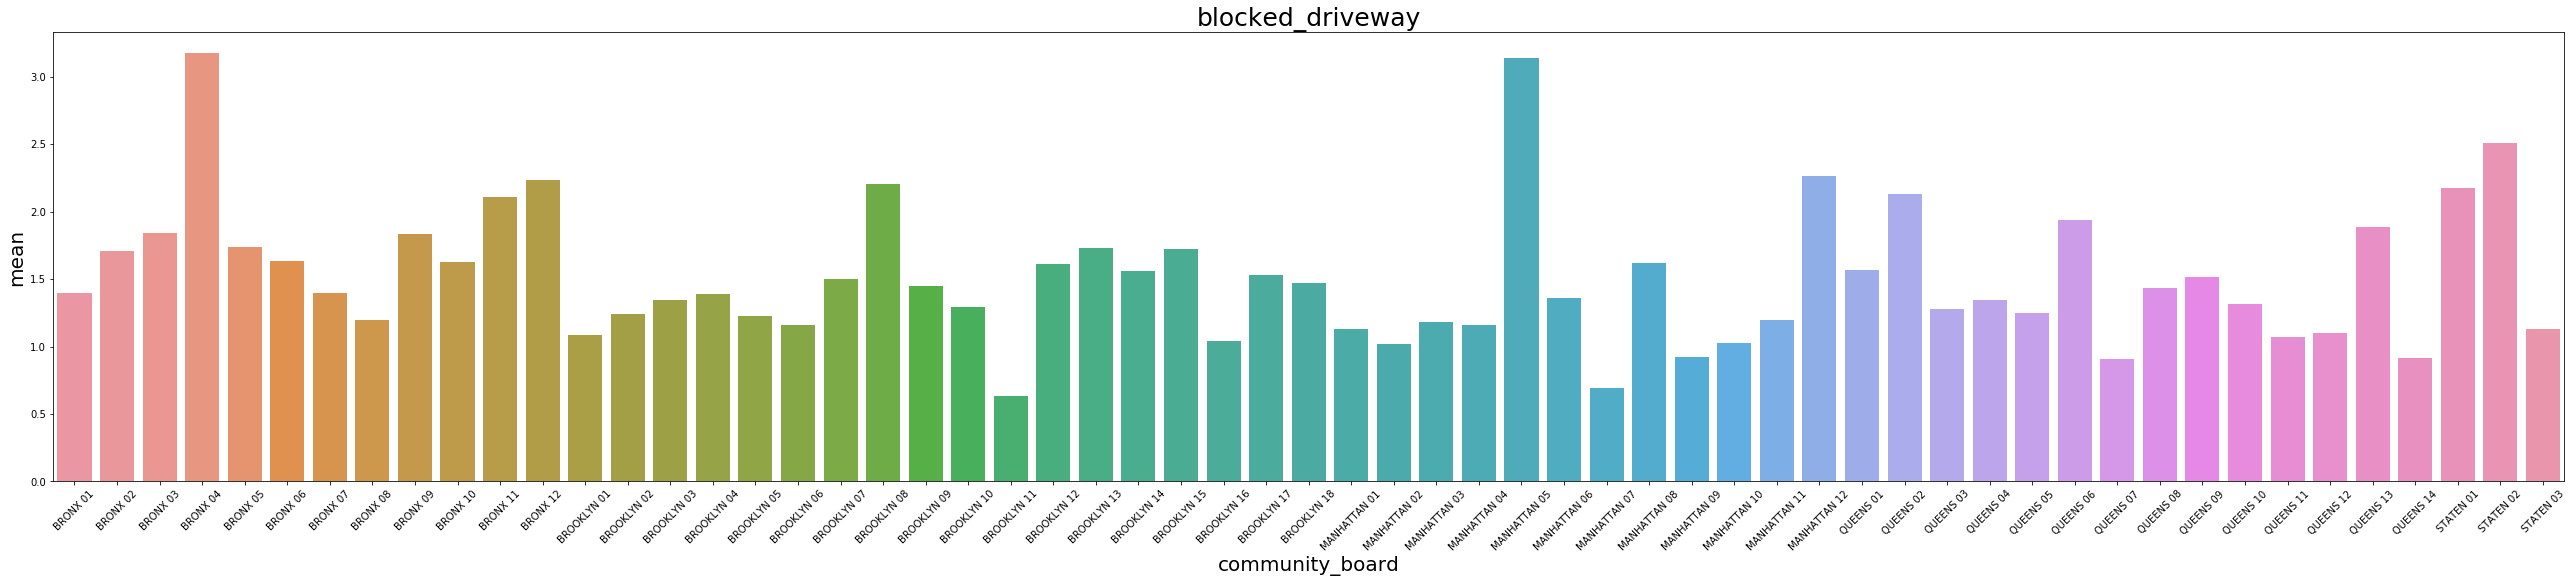

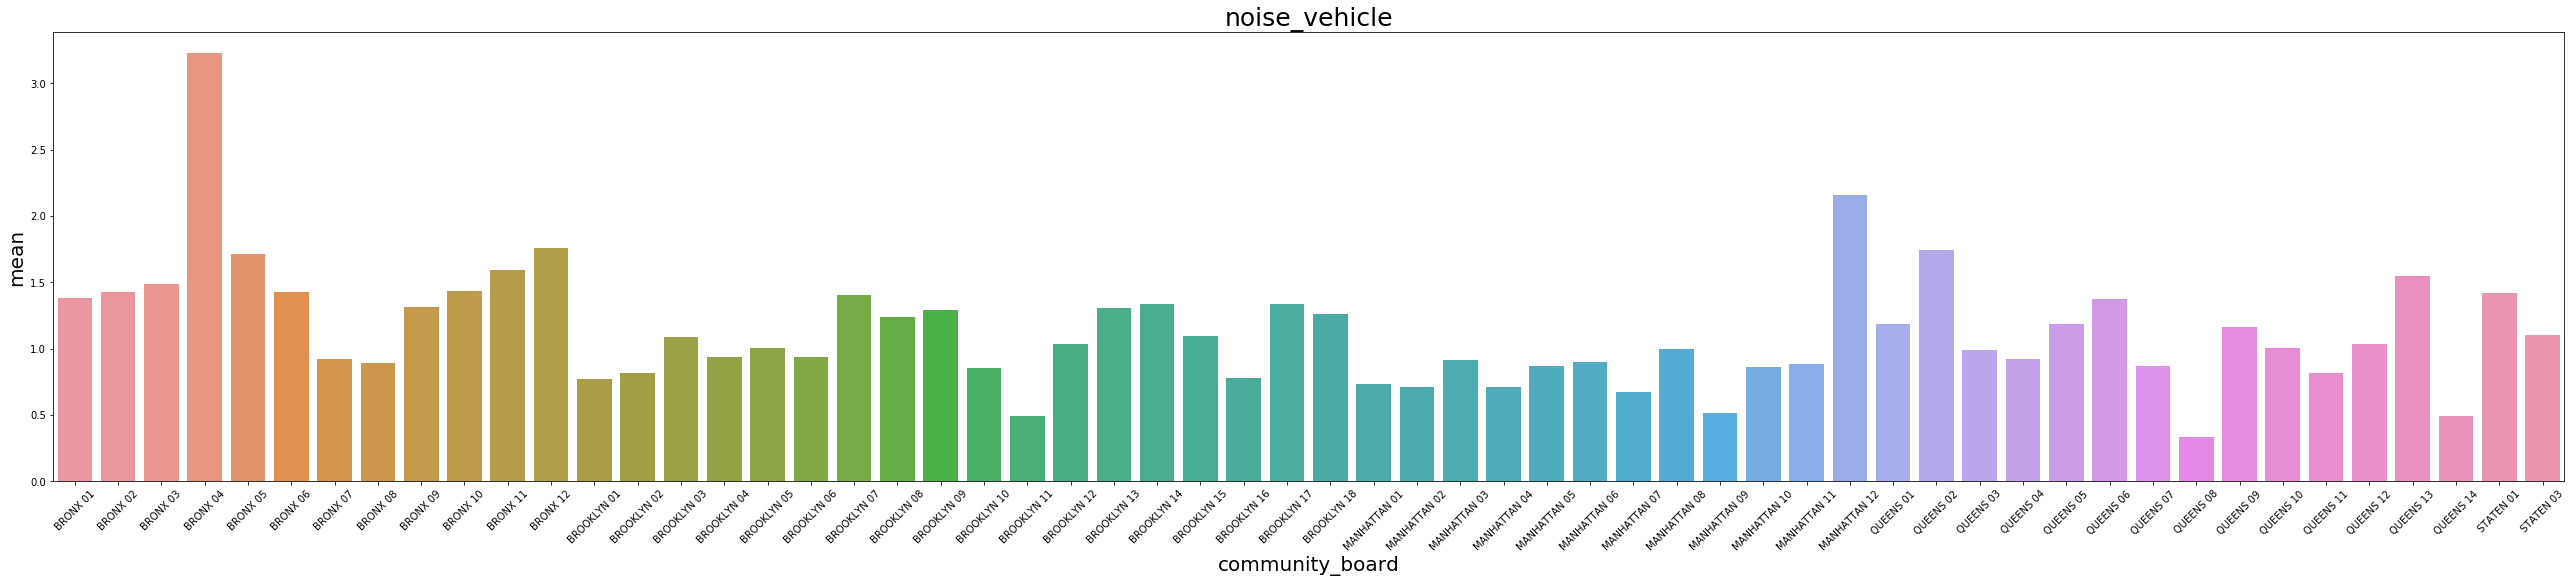

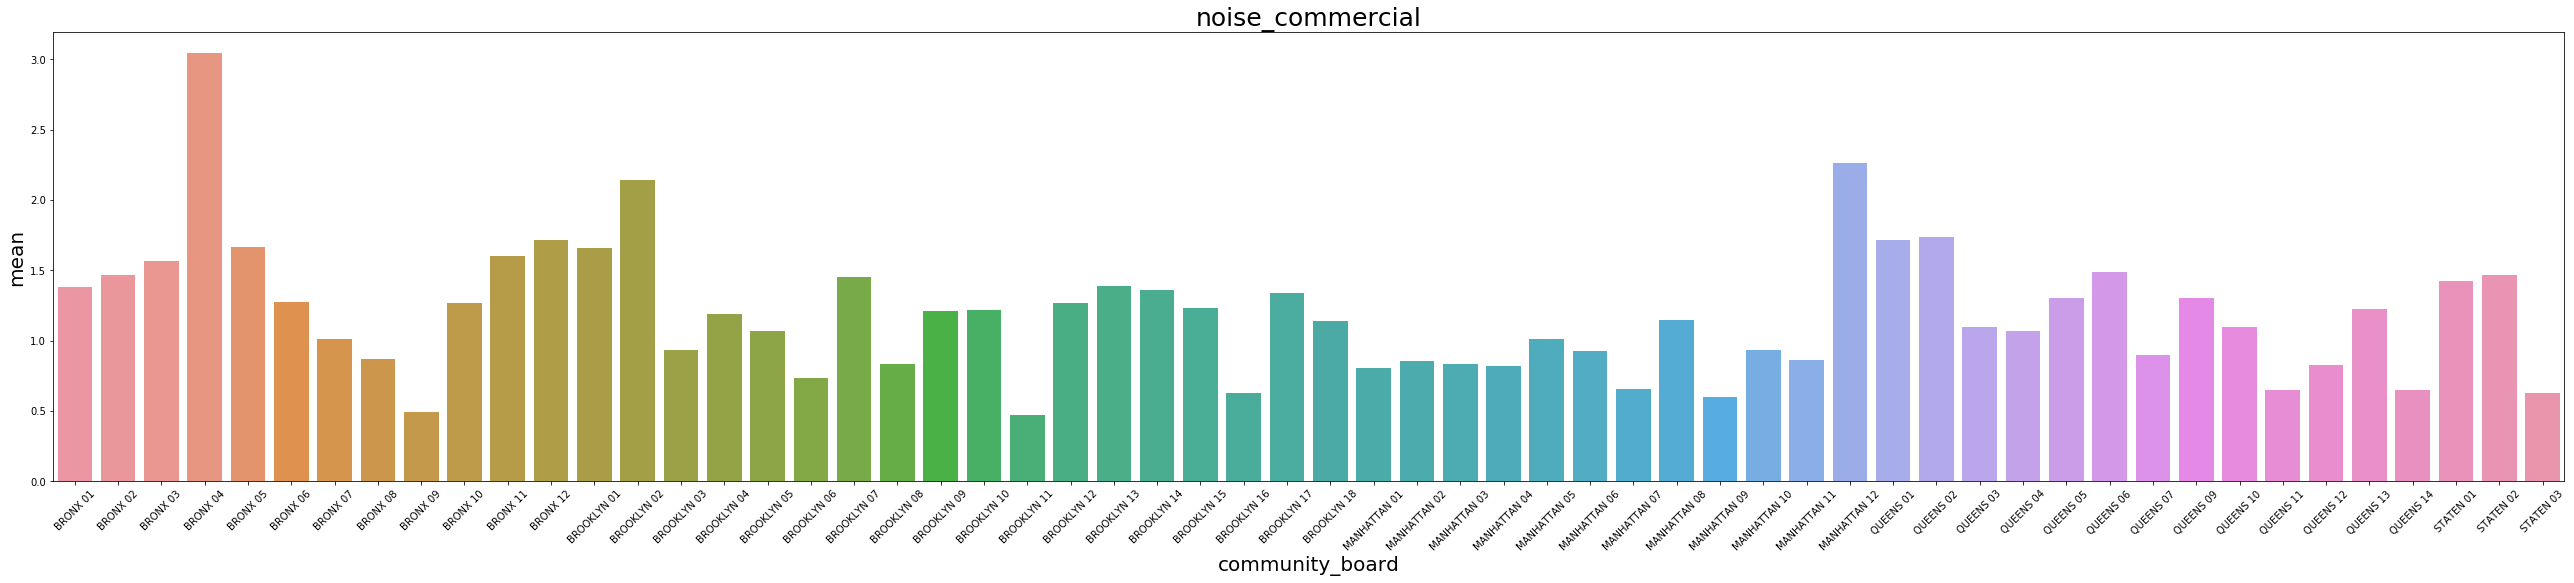

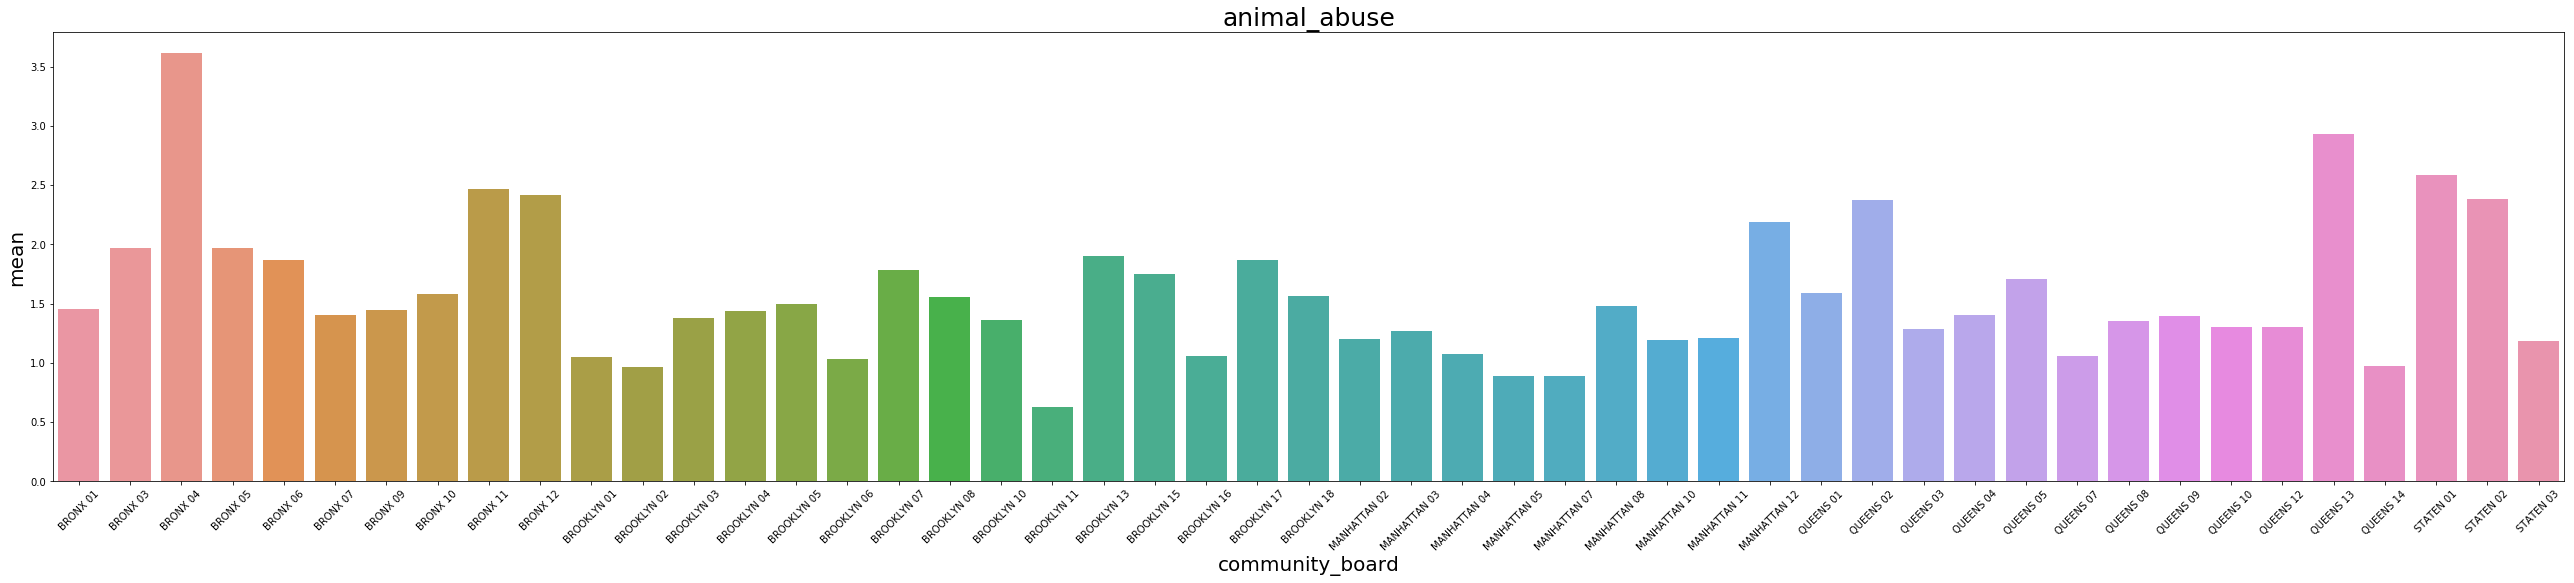

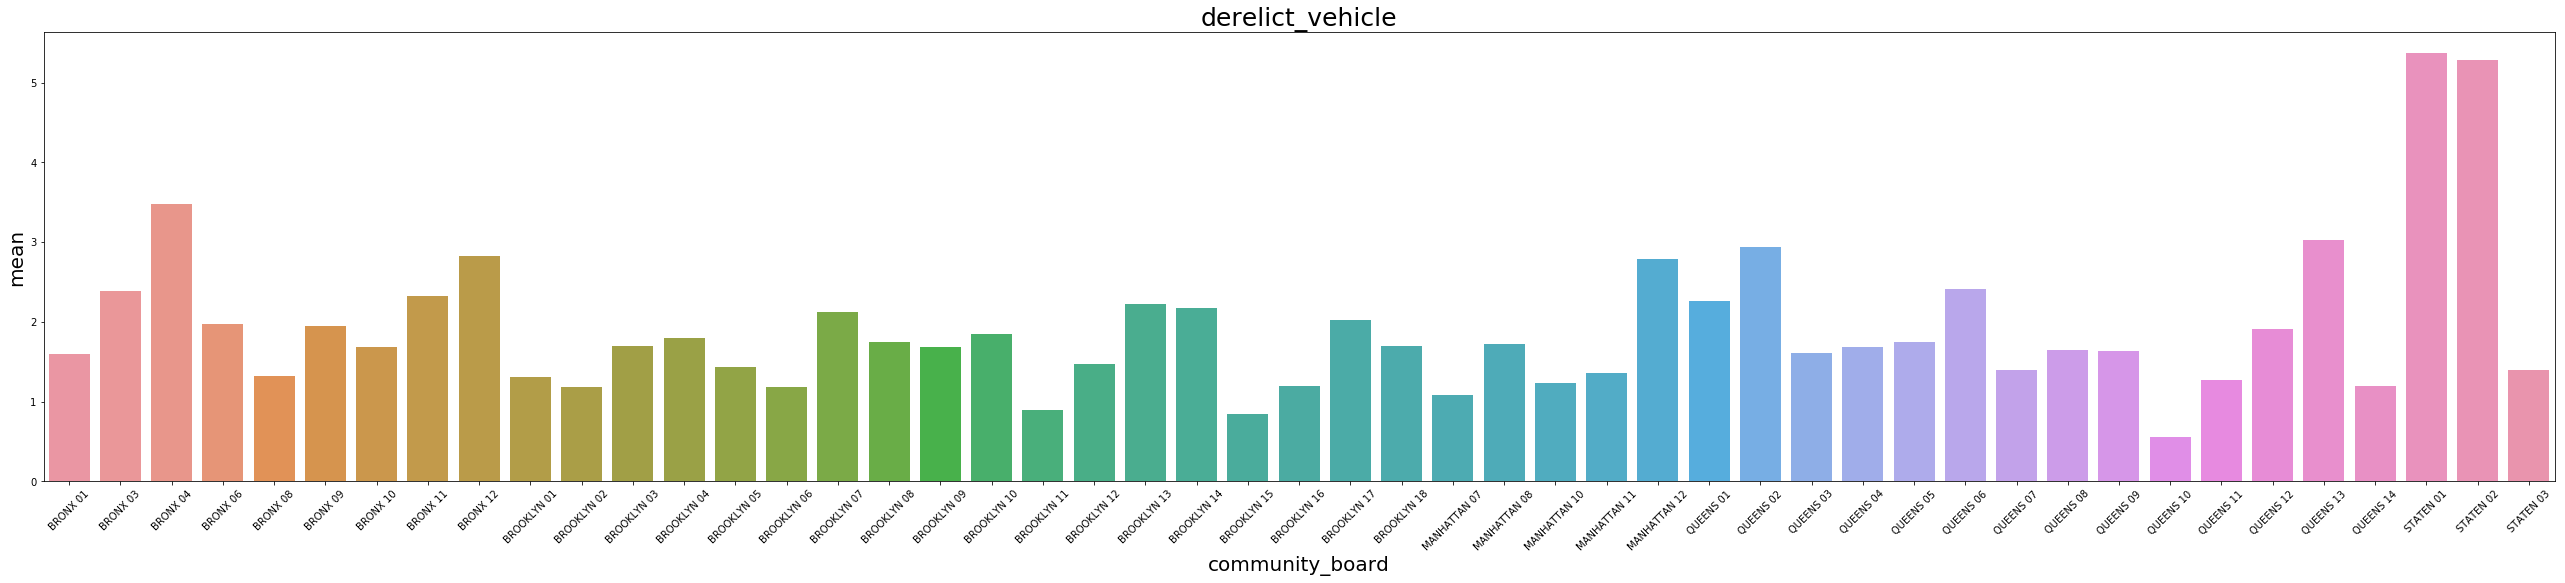

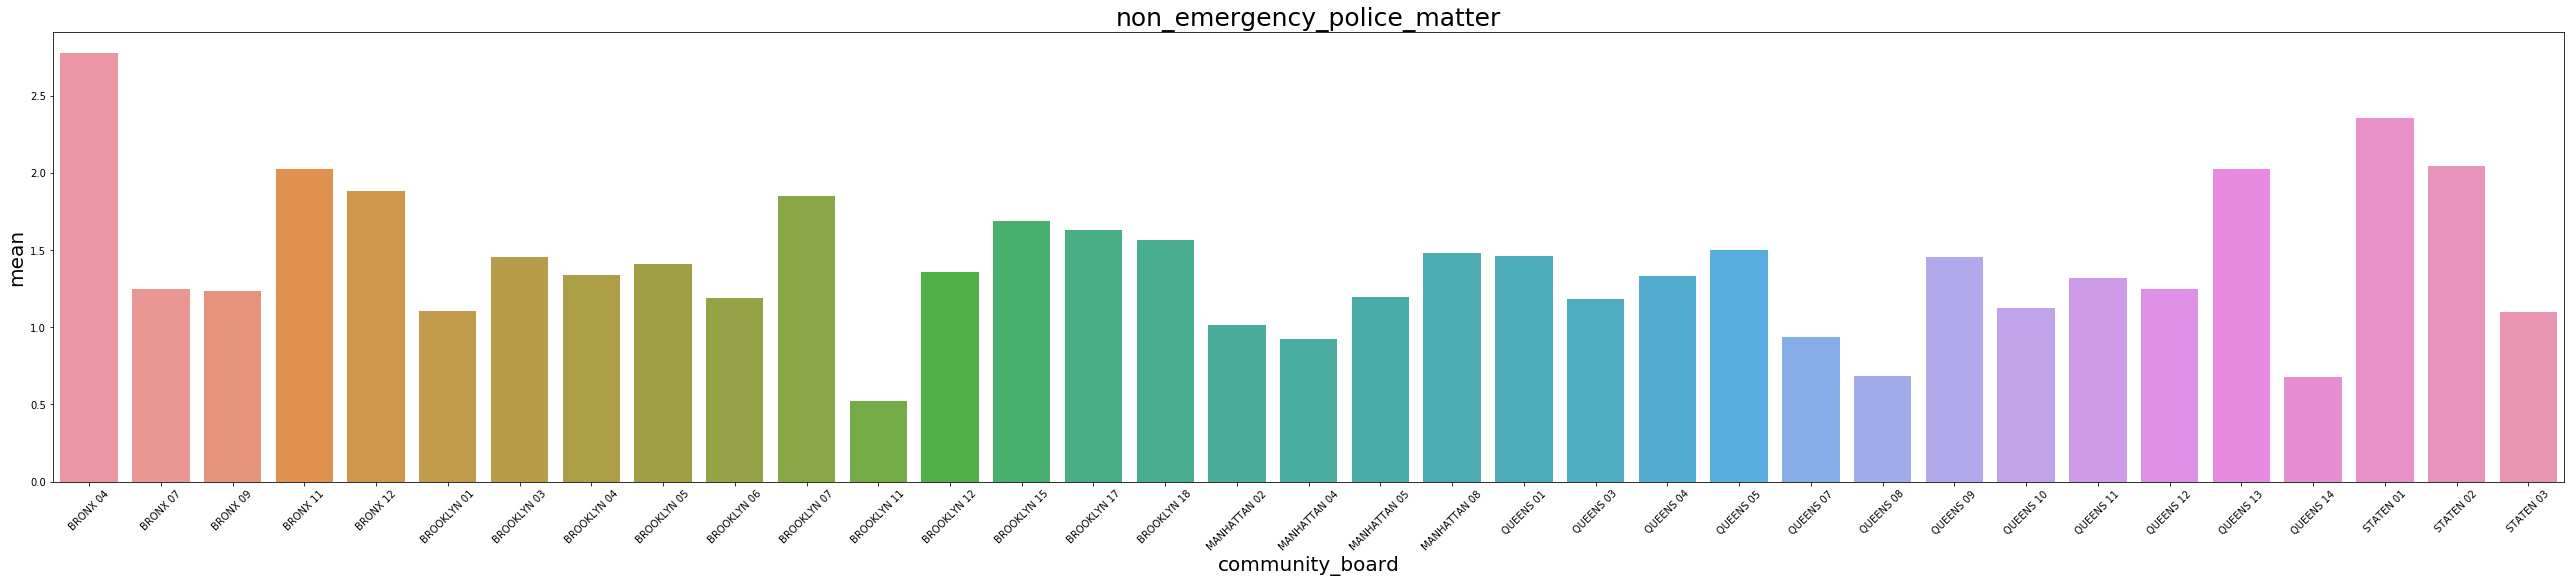

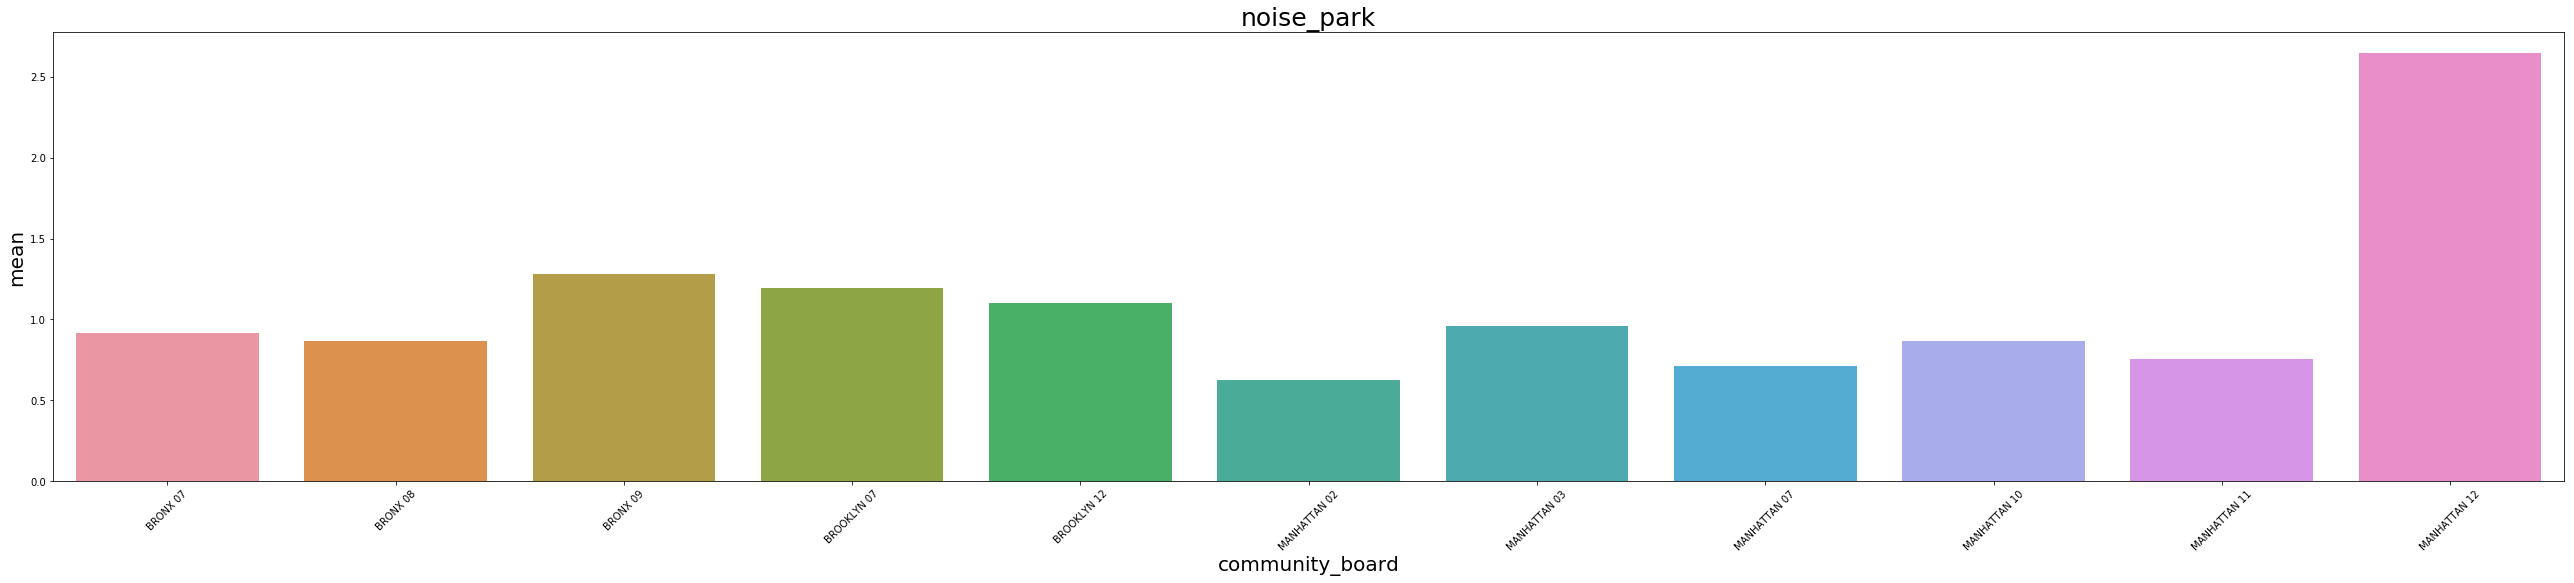

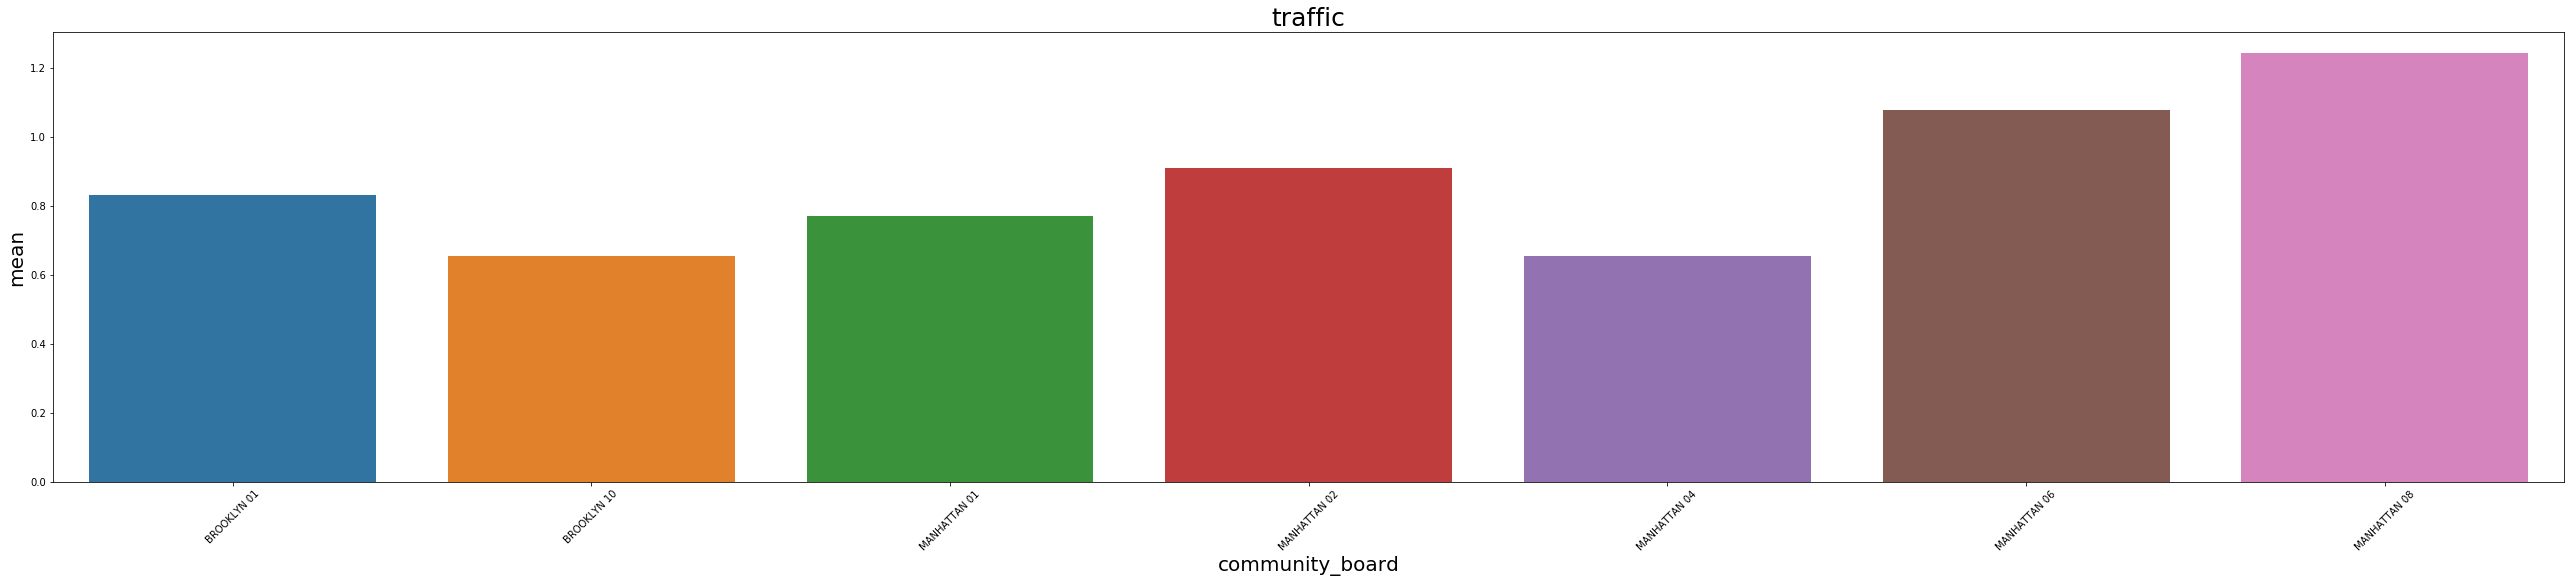

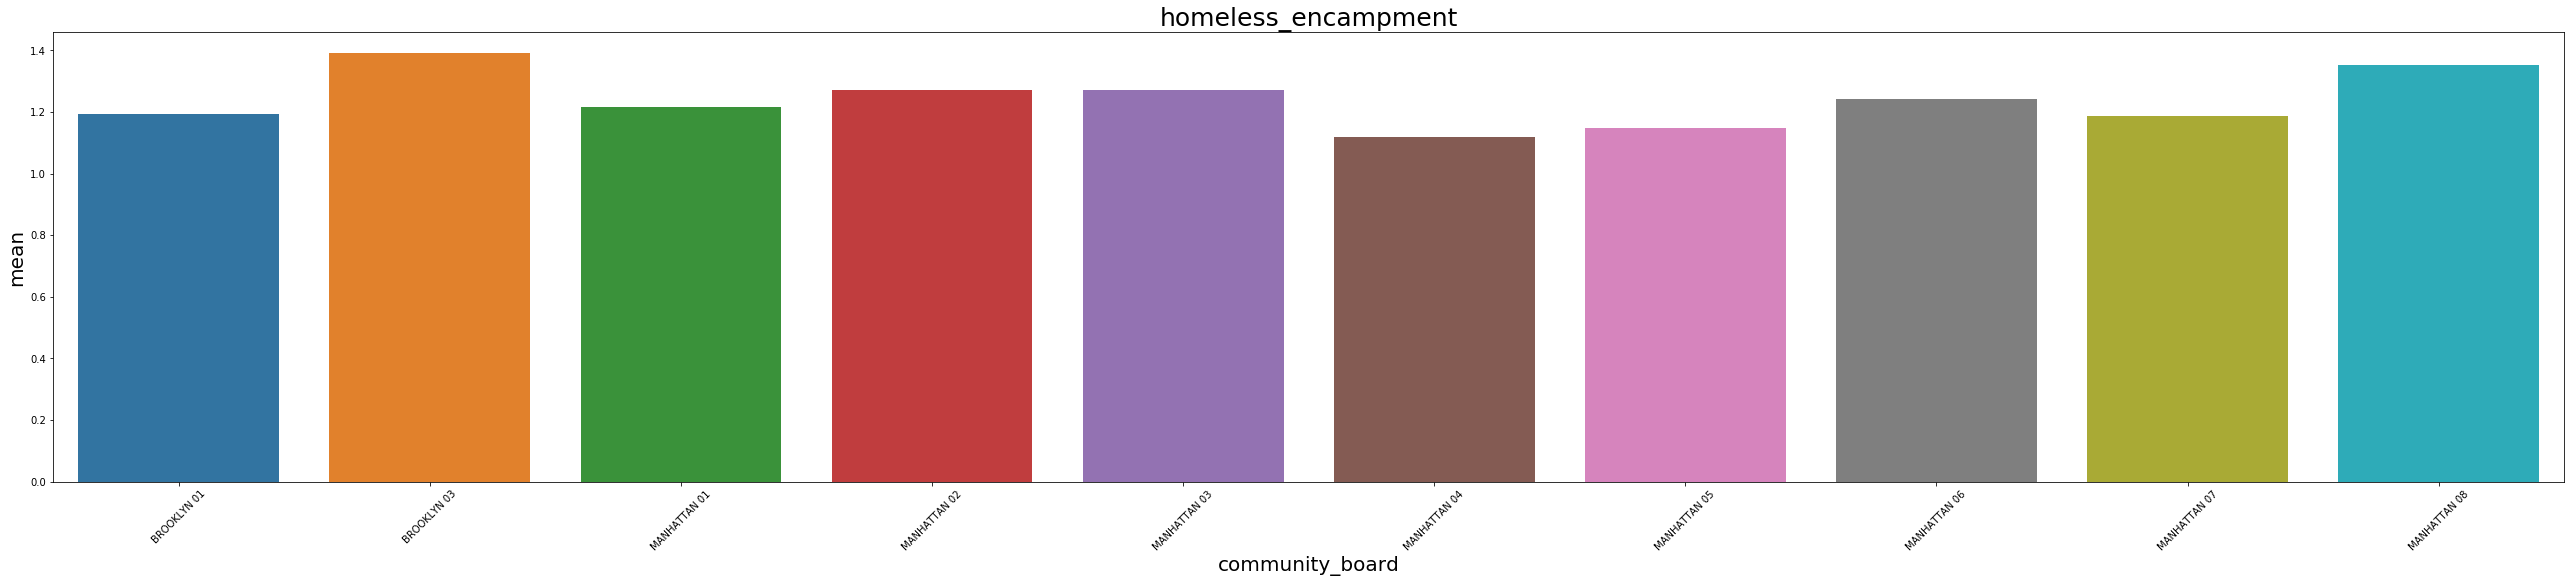

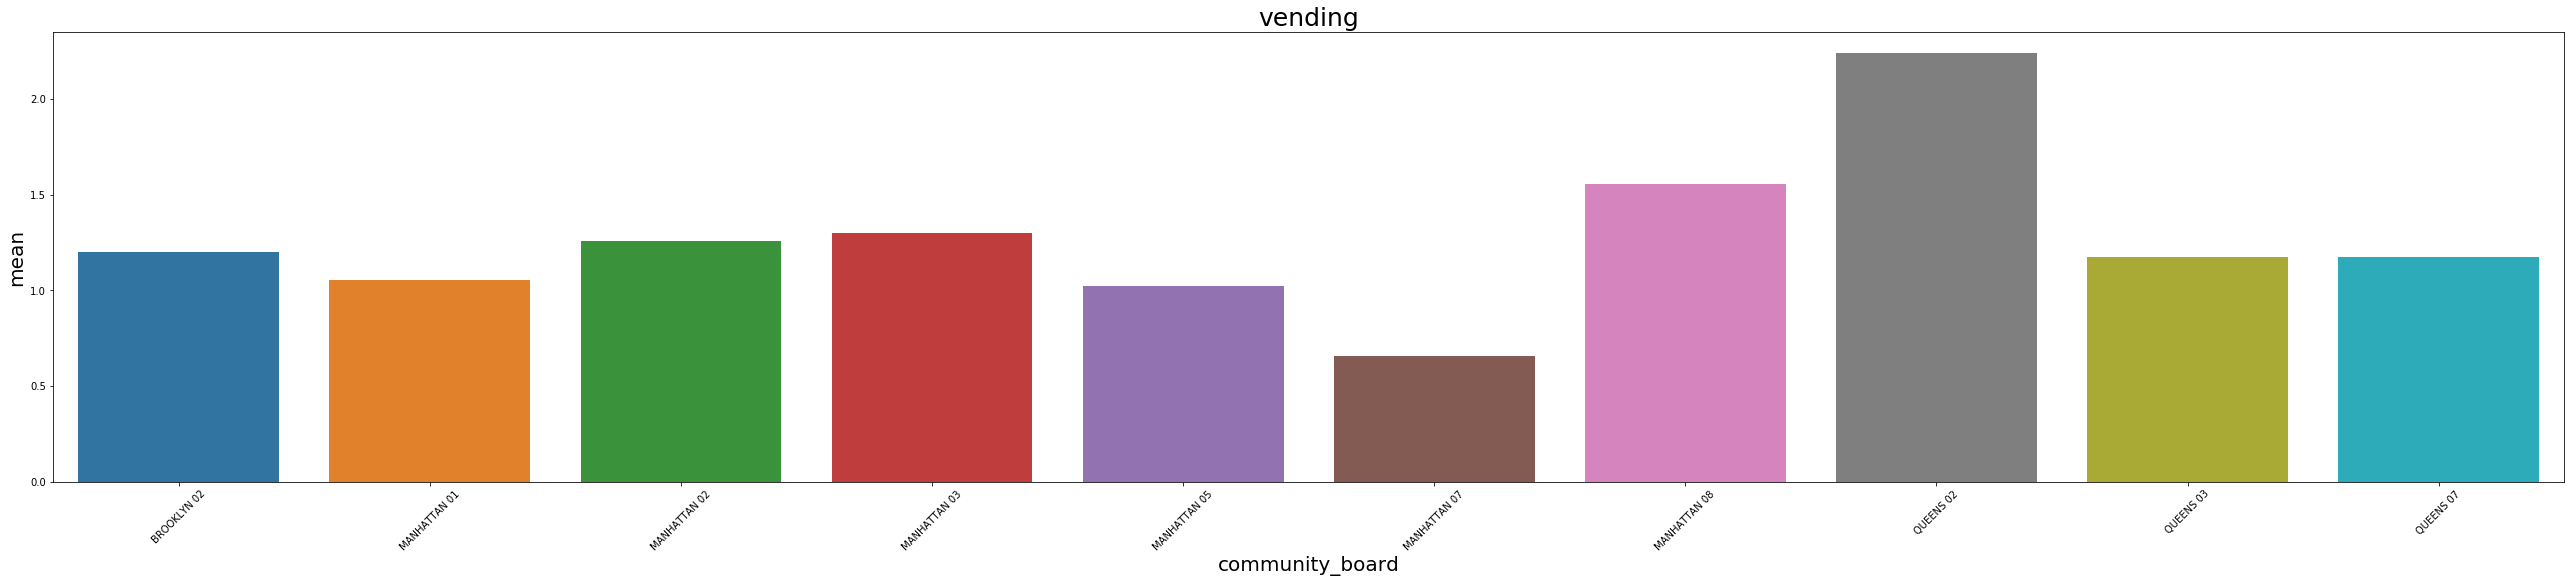

In [479]:
#visually breaks down agency performance by board - log
x= 'community_board'
y= 'mean'
a4_dims = (45, 8.27)




for i in range(len(nypd_complaint_list)):
    fig, ax = plt.subplots(figsize=a4_dims)
    ax.set_title(nypd_complaint_list[i], fontsize=25)
    ax.set_xlabel("Community Board",fontsize=20)
    ax.set_ylabel("Log Mean Completion Time",fontsize=20)
    agencyboardplot = sns.barplot(x, y, data=nypd_complaints[i], ax=ax)
    agencyboardplot.set_xticklabels(agencyboardplot.get_xticklabels(), rotation=45)

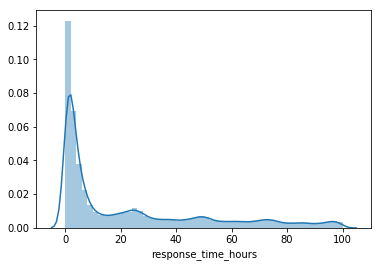

In [480]:
#visualize distribution of complaints resolved between 0 and 100 hours
sns.distplot(db[(db.response_time_hours>0) & (db.response_time_hours<100)].response_time_hours)

In [481]:
#analyzing complaints that took more than 100 hours to solve

hundo = db[db.response_time_hours>100]

In [482]:
agency_list = ['NYPD','HPD','DOT','DOF','DSNY','DEP','DPR','DOB','DOF','DOHMH','DHS','TLC']


hundo['complaint_type'].value_counts()

hundo_grouped = hundo.groupby(['agency','complaint_type'])
hundo_grouped = hundo_grouped.response_time_hours.agg(['mean', 'median', 'std', 'count']).sort_values(by = ['agency', 'mean'], ascending = False)
hundo_grouped = hundo_grouped[hundo_grouped['count'] >200]
hundo_grouped = hundo_grouped.reset_index()
hundo_grouped = hundo_grouped.query('agency in @agency_list')

In [483]:
nypd_hundo = hundo_grouped[hundo_grouped['agency']=='NYPD'].sort_values(by='complaint_type')
hpd_hundo = hundo_grouped[hundo_grouped['agency']=='HPD'].sort_values(by='complaint_type')
dot_hundo = hundo_grouped[hundo_grouped['agency']=='DOT'].sort_values(by='complaint_type')
dsny_hundo = hundo_grouped[hundo_grouped['agency']=='DSNY'].sort_values(by='complaint_type')
dep_hundo = hundo_grouped[hundo_grouped['agency']=='DEP'].sort_values(by='complaint_type')
dpr_hundo = hundo_grouped[hundo_grouped['agency']=='DPR'].sort_values(by='complaint_type')
dob_hundo = hundo_grouped[hundo_grouped['agency']=='DOB'].sort_values(by='complaint_type')
dof_hundo = hundo_grouped[hundo_grouped['agency']=='DOF'].sort_values(by='complaint_type')
dohmh_hundo = hundo_grouped[hundo_grouped['agency']=='DOHMH'].sort_values(by='complaint_type')
tlc_hundo = hundo_grouped[hundo_grouped['agency']=='TLC'].sort_values(by='complaint_type')

agency_list = [nypd_hundo,hpd_hundo,dot_hundo,dsny_hundo,dep_hundo,dpr_hundo,dob_hundo,dof_hundo,dohmh_hundo,tlc_hundo]

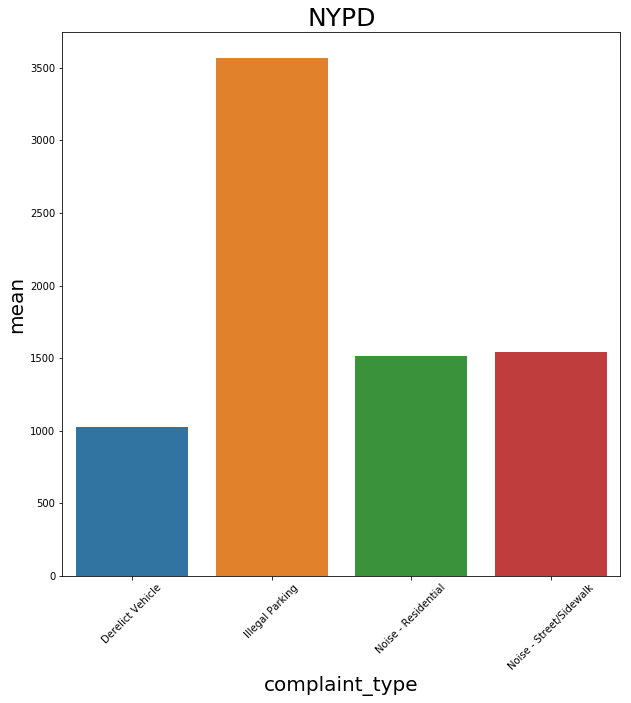

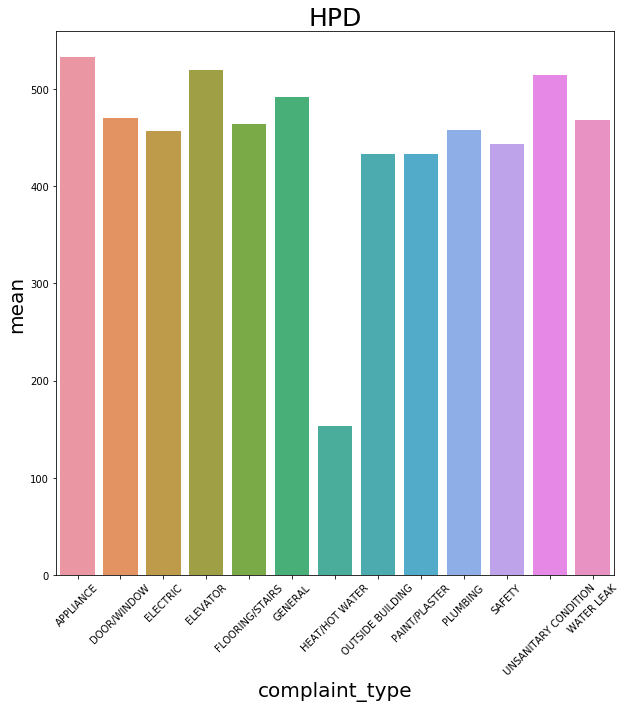

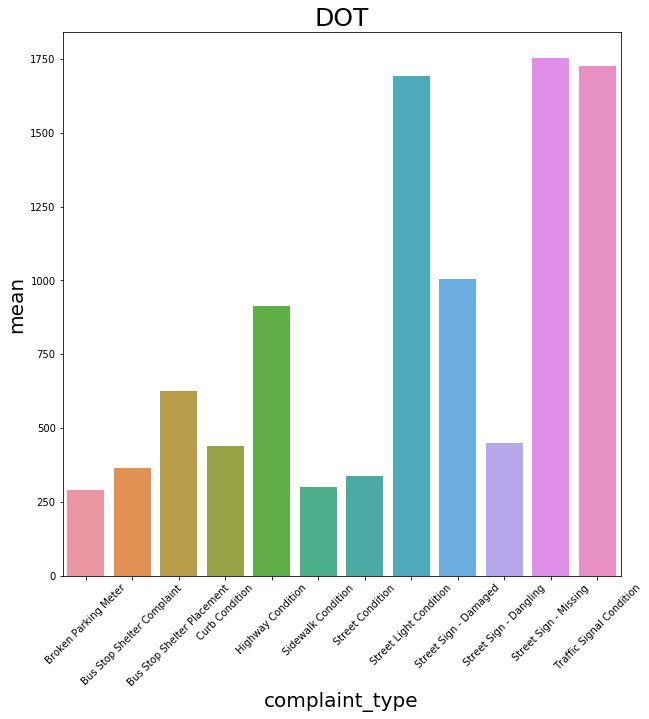

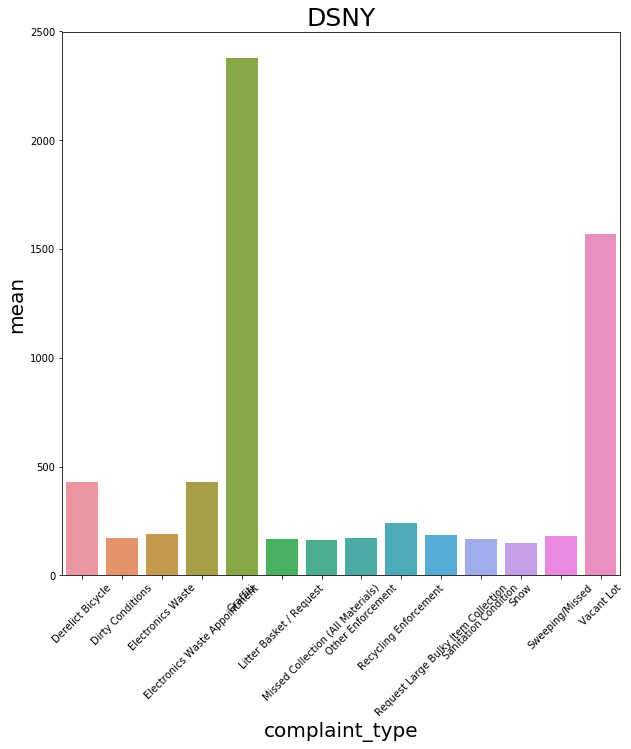

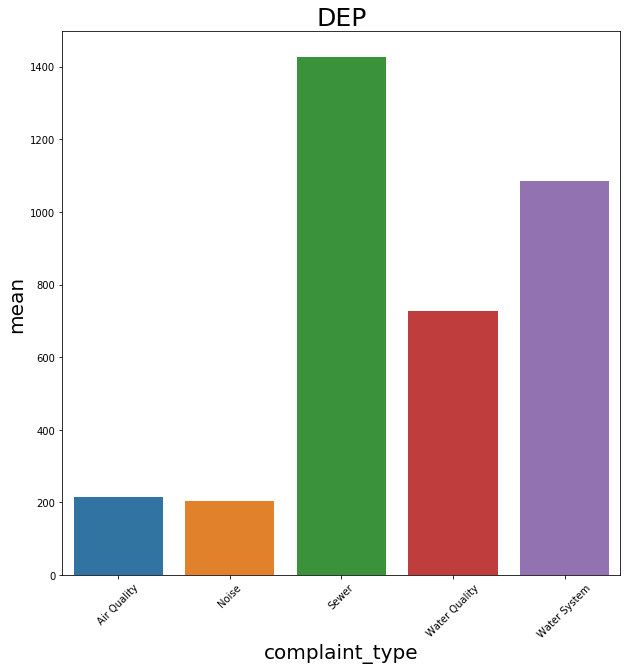

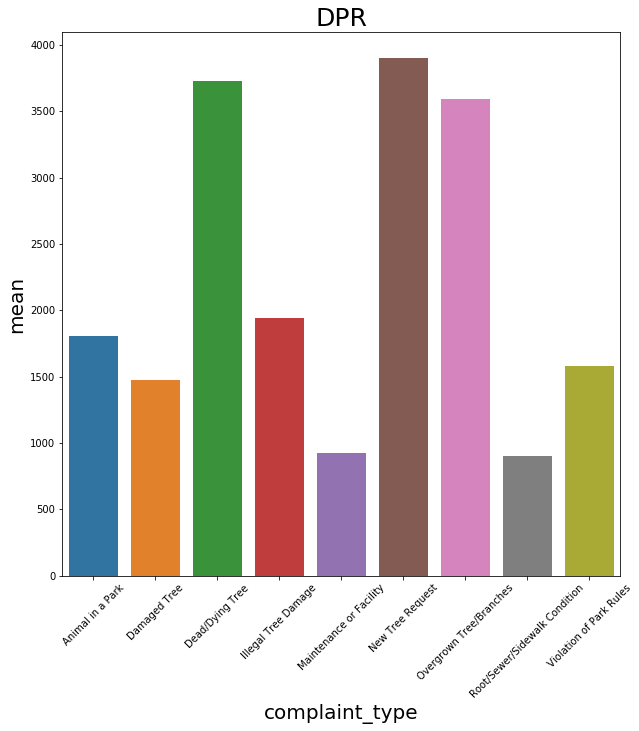

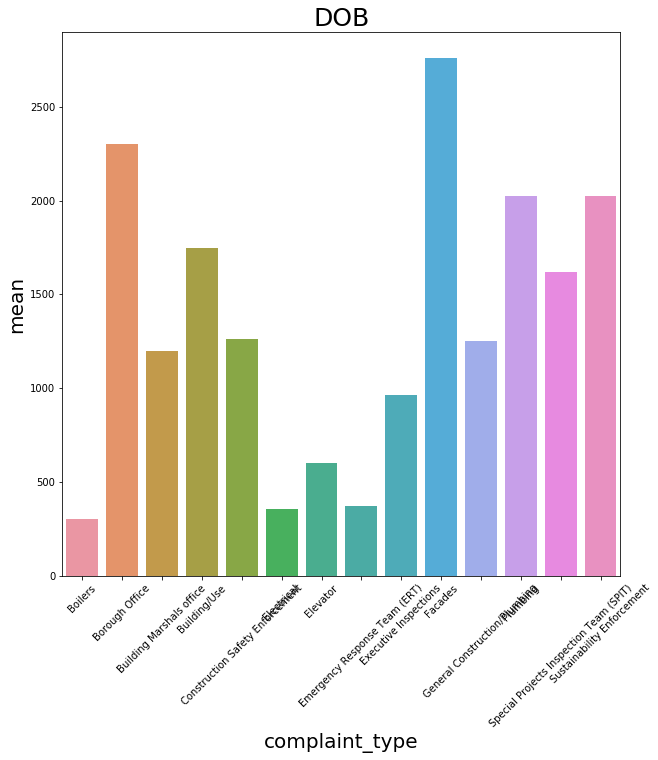

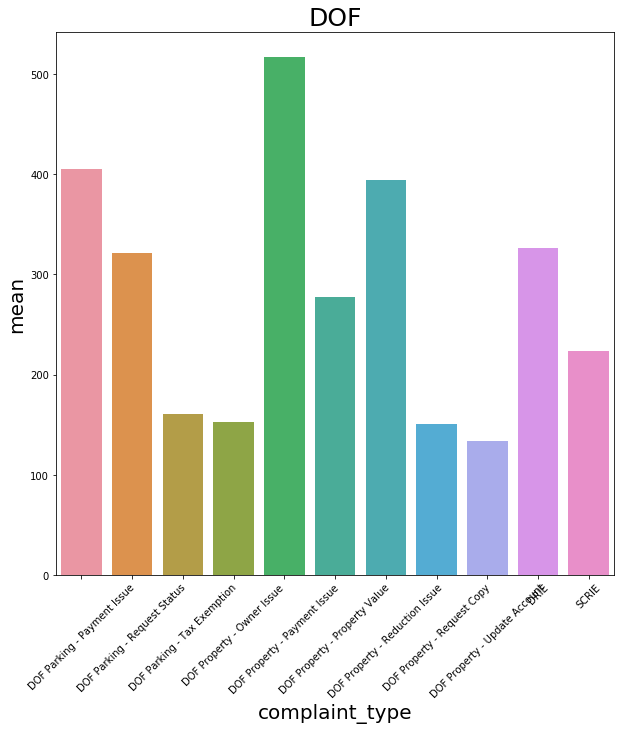

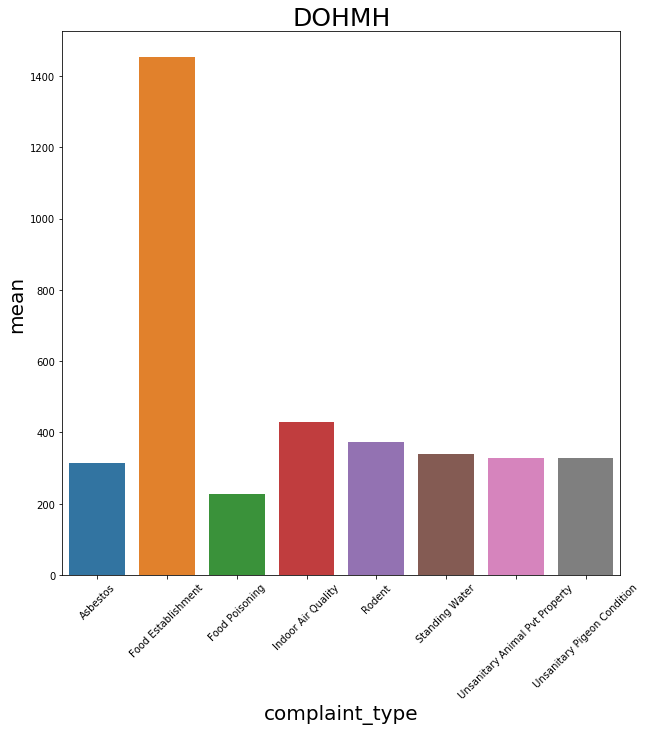

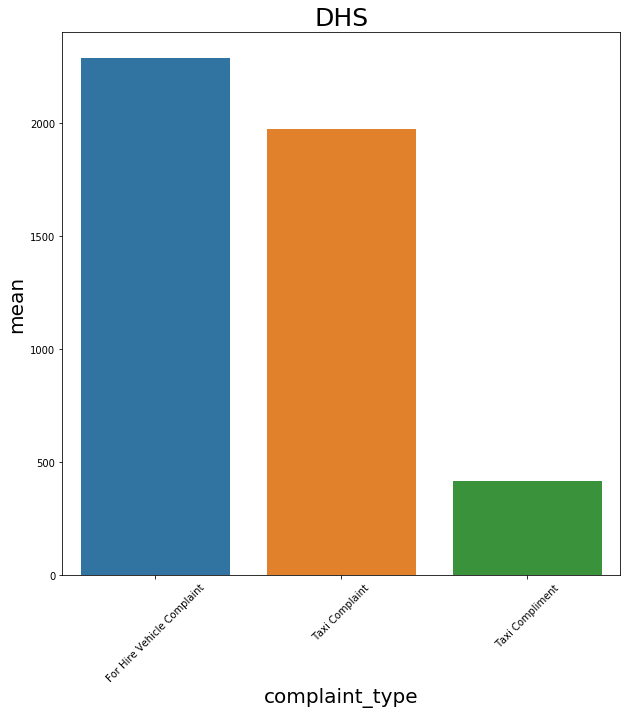

In [484]:
#visually breaks down complaints that take more than 100 hours to resolve by agency
x= 'complaint_type'
y= 'mean'
a4_dims = (10, 10)

for i in range(len(agency_list)):
    fig, ax = plt.subplots(figsize=a4_dims)
    ax.set_title(agency_name_list[i], fontsize=25)
    ax.set_xlabel("Complaint Type",fontsize=20)
    ax.set_ylabel("Mean Completion Time",fontsize=20)
    hundoboardplot = sns.barplot(x, y, data=agency_list[i], ax=ax)
    hundoboardplot.set_xticklabels(hundoboardplot.get_xticklabels(), rotation=45)


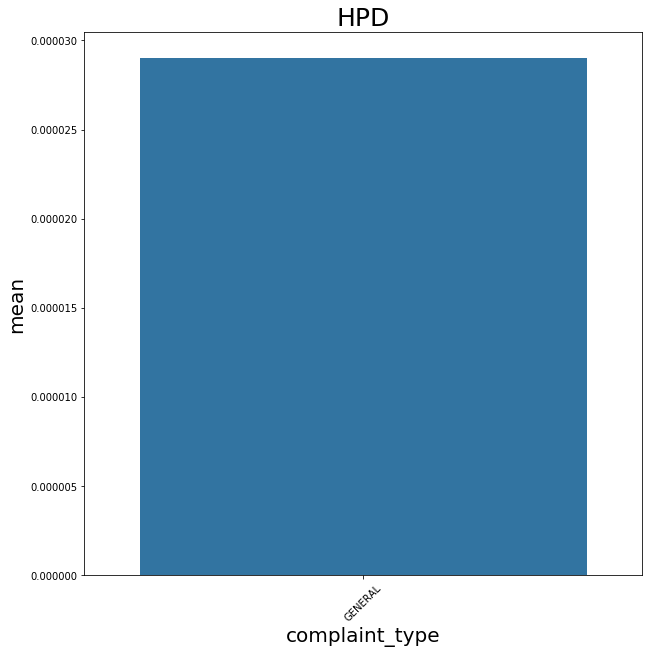

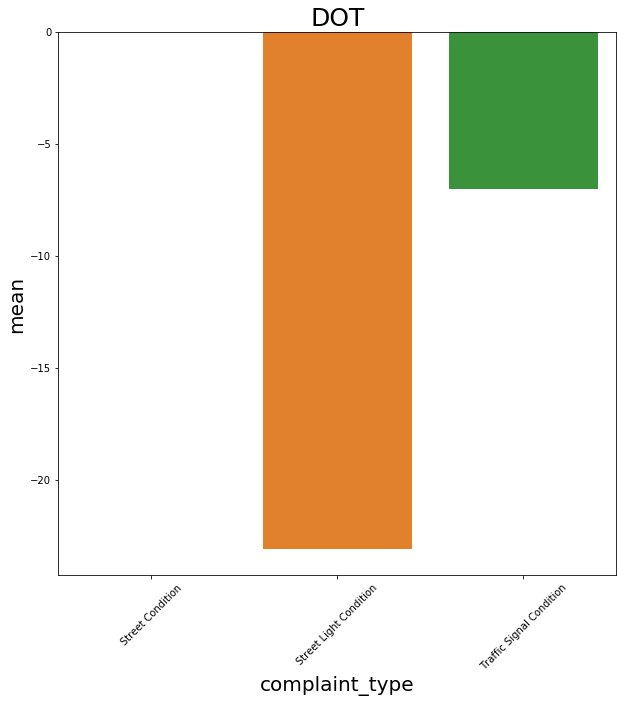

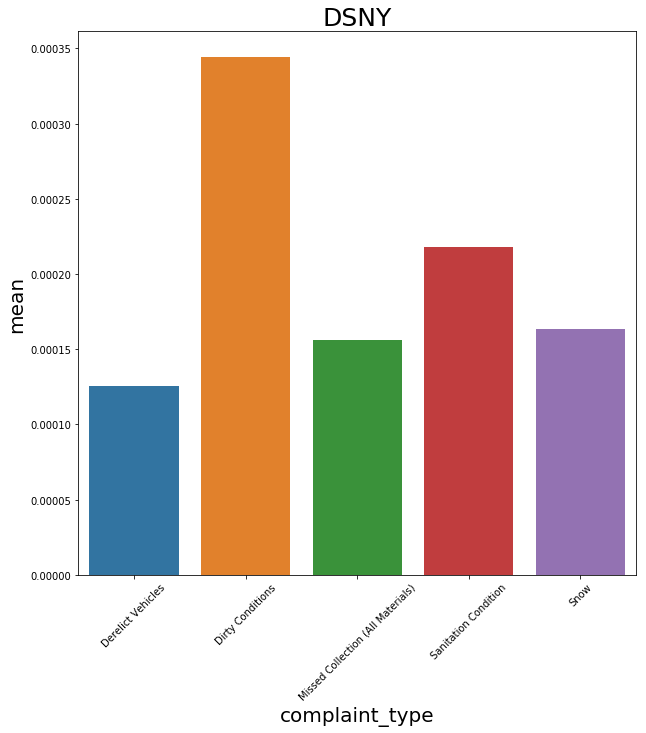

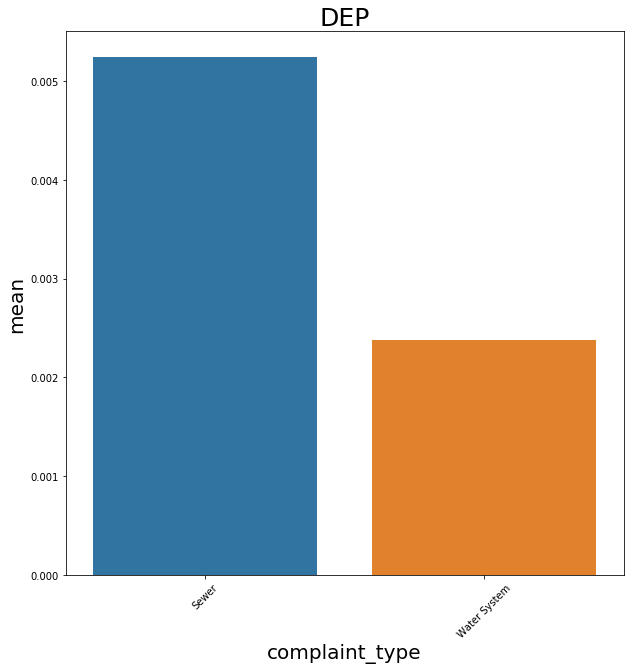

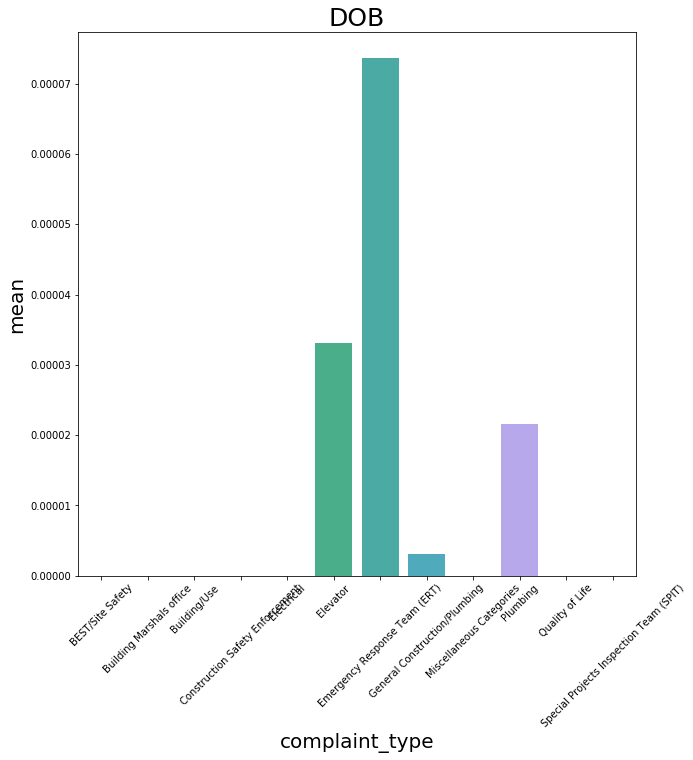

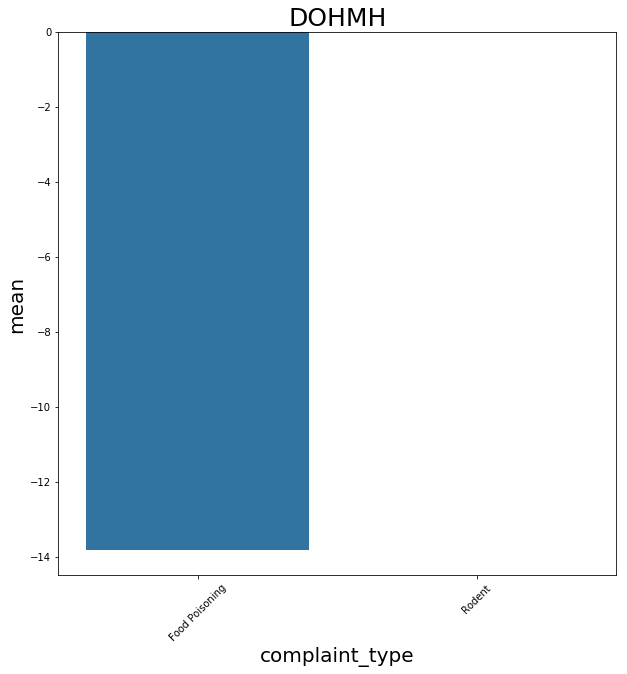

In [485]:
# analyze complaints resolved in under 120 seconds

under2 = db[db.under_120 == 1]

under2_grouped = under2.groupby(['agency','complaint_type'])
under2_grouped = under2_grouped.response_time_hours.agg(['mean', 'median', 'std', 'count']).sort_values(by = ['agency', 'mean'], ascending = False)
under2_grouped = under2_grouped[under2_grouped['count'] >200]
under2_grouped = under2_grouped.reset_index()



hpd_under2 = under2_grouped[under2_grouped['agency']=='HPD'].sort_values(by='complaint_type')
dot_under2 = under2_grouped[under2_grouped['agency']=='DOT'].sort_values(by='complaint_type')
dsny_under2 = under2_grouped[under2_grouped['agency']=='DSNY'].sort_values(by='complaint_type')
dep_under2 = under2_grouped[under2_grouped['agency']=='DEP'].sort_values(by='complaint_type')
dob_under2 = under2_grouped[under2_grouped['agency']=='DOB'].sort_values(by='complaint_type')
dohmh_under2 = under2_grouped[under2_grouped['agency']=='DOHMH'].sort_values(by='complaint_type')
tlc_under2 = under2_grouped[under2_grouped['agency']=='TLC'].sort_values(by='complaint_type')

under_agency_name_list = ['HPD','DOT','DSNY','DEP','DOB','DOHMH']


under_agency_list = [hpd_under2,dot_under2,dsny_under2,dep_under2,dob_under2,dohmh_under2]

#visually breaks down agency performance by board
x= 'complaint_type'
y= 'mean'
a4_dims = (10, 10)

for i in range(len(under_agency_name_list)):
    fig, ax = plt.subplots(figsize=a4_dims)
    ax.set_title(under_agency_name_list[i], fontsize=25)
    ax.set_xlabel("Complaint Type",fontsize=20)
    ax.set_ylabel("Mean Completion Time",fontsize=20)
    underbarplots = sns.barplot(x, y, data=under_agency_list[i], ax=ax)
    underbarplots.set_xticklabels(underbarplots.get_xticklabels(), rotation=45)

In [486]:
#A look at all complaint types with at least 200 complaints

db_grouped = db.groupby(['agency', 'complaint_type'])
db_grouped = db_grouped.response_time_hours.agg(
    ['mean','median','std','count', 'min', 'max']
).sort_values(by = ['agency', 'std'],ascending=False)
db_grouped = db_grouped[db_grouped['count']>200]

In [487]:
db_as_df = db_grouped.reset_index()

In [488]:
# determining complaint types' percentage of total

complaint_types = list(db['complaint_type'].unique())


complaint_values = []
for i in range(len(complaint_types)):
    x = round(len(db[db['complaint_type']==complaint_types[i]])/len(db),2)
    complaint_values.append(x)
    
#results in scalar, makes making a dataframe more difficult    
#complaint_rates = dict(zip(complaint_types, complaint_values))
complaint_rates_as_df =  pd.DataFrame(
    {'Complaint': complaint_types,
     'Percentage': complaint_values
    })
    

In [489]:
complaint_rates_as_df = complaint_rates_as_df.sort_values(by='Percentage', ascending=False).reset_index()

In [490]:
#grab the top 50 complaints by percentage of total complaints
top_complaints = list(complaint_rates_as_df['Complaint'][:50])

In [491]:
#grab the response times associated with top 50 most common complaints

complaint_times = [list([]) for _ in range(len(top_complaints))]

for i in range(len(top_complaints)):
    complaint_times[i].append(
        np.array(db[db['complaint_type']==top_complaints[i]]['response_time_hours']))
    complaint_times[i] = complaint_times[i][0]
    


In [492]:
#remove nulls
def no_nulls(nested_list):
    for lst in range(len(nested_list)):
        nested_list[i] = [x for x in nested_list[i] if x==x]
    return nested_list

complaint_times = no_nulls(complaint_times)

In [493]:
from scipy.stats import iqr
from scipy.stats import zscore

#get z-scores for complaint times
def get_zscores(lst):
    zscore_lst = []
    for i in range(len(lst)):
        zscore_lst.append(zscore(lst[i]))
    return zscore_lst

zscores = get_zscores(complaint_times)
zscores_lists = [array.tolist() for array in zscores]
zscore_flat_list = [item for sublist in zscores_lists for item in sublist]


In [494]:
#create dataframe with zscores and iqr of zscores 

dist_df = pd.DataFrame({'Type': top_complaints, 'Times': complaint_times, 'ZScores': zscores})

iqr_zscores = [iqr(i) for i in zscores]
        
dist_df['iqr_zscore'] = iqr_zscores

In [495]:
# create a new dataframe combining all instances of a complaint type's appearance, the iqr_zscore for the complaint
#type, the time for that individual complaint, and the zscore for the individual complaint
dist_df_spread  = dist_df
Time = dist_df_spread.apply(lambda x: pd.Series(x['Times']),axis=1).stack().reset_index(level=1, drop=True)
Time.name = 'Time'
dist_df_spread = dist_df_spread.drop(['Times', 'ZScores'], axis=1).join(Time)

dist_df_spread['zscore'] = zscore_flat_list
dist_df_spread

,Type,iqr_zscore,Time,zscore
0,HEAT/HOT WATER,0.645842,129.523889,0.656540
0,HEAT/HOT WATER,0.645842,163.867222,1.029956
0,HEAT/HOT WATER,0.645842,68.533056,-0.006617
0,HEAT/HOT WATER,0.645842,140.558611,0.776521
0,HEAT/HOT WATER,0.645842,187.249444,1.284192
0,HEAT/HOT WATER,0.645842,19.608611,-0.538574
0,HEAT/HOT WATER,0.645842,154.041111,0.923116
0,HEAT/HOT WATER,0.645842,187.215278,1.283821
0,HEAT/HOT WATER,0.645842,230.809167,1.757819
0,HEAT/HOT WATER,0.645842,130.016944,0.661901


In [496]:
#export for visual analysis in R (see R script in repo)

dist_df_spread.to_csv('2018_complaint_zscore_spread.csv')

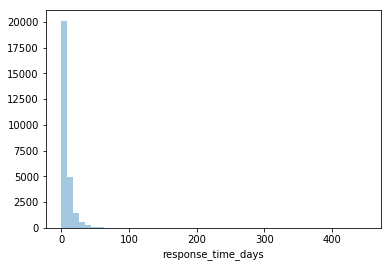

In [497]:
#quick visual of rodent response times
sns.distplot(db[db['complaint_type']=='Rodent']['response_time_days'], kde=False)

In [498]:
#analyze lead complaint resolutions
lead = db[db['complaint_type']=='Lead']
lead['resolution_description'].value_counts()

the department of environmental protection investigated this complaint and created a service request to have a lead test kit sent to the complainant.                                                                                                                                  8836
the department of environment protection inspected your complaint but could not find the problem you reported. if the condition persists, please call 311 (or 212-639-9675 if calling from a non-new york city area code) with more detailed information to submit a new complaint.    2   
the department of environmental protection investigated this complaint and determined it is an inside condition within the complainant's property.                                                                                                                                     1   
the department of environmental protection investigated this complaint and found there was no sewer back up in the city system at the time of the in

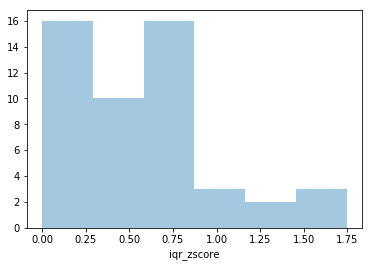

In [499]:
#plot iqrs of zscores
sns.distplot(dist_df['iqr_zscore'], kde=False)

In [500]:
print('iqr of iqrs: ', iqr(dist_df.iqr_zscore), '\n'
      'mean of iqrs: ', dist_df.iqr_zscore.mean(), '\n'
      'max: ', dist_df.iqr_zscore.max(), '\n'
      'min: ', dist_df.iqr_zscore.min())


iqr of iqrs:  0.6186351015136653 
mean of iqrs:  0.550065156900985 
max:  1.7455252998124018 
min:  0.0


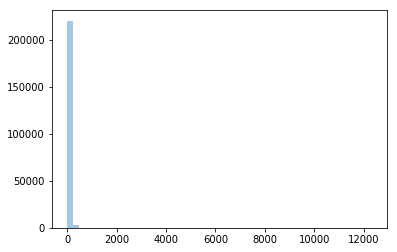

In [501]:
sns.distplot(dist_df['Times'][0], kde=False)

0.6458423852078949


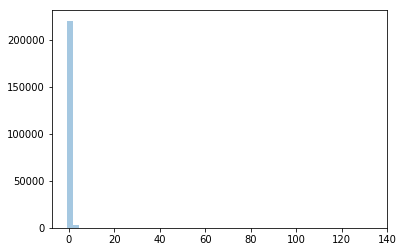

In [502]:
print(dist_df.iqr_zscore[0])
sns.distplot(dist_df.ZScores[0], kde=False)

In [503]:
#determine how many duplicate cases for consumer complaints with response time less than 5 days

db[(db['complaint_type']=='Consumer Complaint')&(db['response_time_days']<5)].res_desc.value_counts()


ongoing            3882
no_action_taken    2114
wrong_agency       1403
string             460 
ambiguous          48  
Name: res_desc, dtype: int64

In [504]:
#seeing duplicates as a percentage of all "consumer complaint" complaints addressed in under 5 days
len(db[(db.complaint_type == "Consumer Complaint")&(db['response_time_days']<5)&(db.res_desc == "duplicate")])/len(db[(db['complaint_type']=='Consumer Complaint')&(db['response_time_days']<5)])

0.0

In [505]:
db[(db['complaint_type']=='Consumer Complaint')&(db['response_time_hours']<200)].res_desc.value_counts()

ongoing            3901
no_action_taken    2119
wrong_agency       1404
string             462 
ambiguous          48  
Name: res_desc, dtype: int64

fixed              2941
did_not_observe    2650
wrong_agency       140 
duplicate          16  
Name: res_desc, dtype: int64 1 Missed Collection                  1560
1R Missed Recycling-All Materials    1197
2 Bulk-Missed Collection             932 
2R Bulk-Missed Recy Collection       550 
1RG Missed Recycling Paper           475 
1RB Missed Recycling - M/G/Pl        464 
1RO Missed Recycling Organics        459 
1L Missed Recycling Leaves           94  
1C Uncollected Xmas Trees            16  
Name: descriptor, dtype: int64 01 STATEN ISLAND        949
07 QUEENS               938
01 BROOKLYN             476
02 STATEN ISLAND        358
12 QUEENS               322
06 BROOKLYN             303
03 STATEN ISLAND        297
18 BROOKLYN             282
13 QUEENS               191
10 BROOKLYN             174
12 BROOKLYN             151
14 QUEENS               134
08 QUEENS               102
17 BROOKLYN             94 
15 BROOKLYN             77 
11 BROOKLYN             70 
10 MANHATTAN      

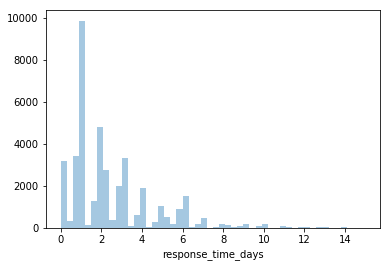

In [506]:
#a summary of results related to the complaint "missed collection (all materials)"
print(db[(db['complaint_type']=='Missed Collection (All Materials)')&(db['response_time_days']>5)].res_desc.value_counts(),
      db[(db['complaint_type']=='Missed Collection (All Materials)')&(db['response_time_days']>5)].descriptor.value_counts(),
      db[(db['complaint_type']=='Missed Collection (All Materials)')&(db['response_time_days']>5)]['community_board'].value_counts(),
      db[(db['complaint_type']=='Missed Collection (All Materials)')&(db['response_time_days']<5)].res_desc.value_counts(),
      db[(db['complaint_type']=='Missed Collection (All Materials)')&(db['response_time_days']<5)].descriptor.value_counts(),
      db[(db['complaint_type']=='Missed Collection (All Materials)')&(db['response_time_days']<5)]['community_board'].value_counts())
sns.distplot(db[
    (db['complaint_type']=='Missed Collection (All Materials)')&
    (db['response_time_days']<15)].response_time_days, kde=False)

In [507]:
#create missed collection complaint df, aggregate by count
missed_collection = db[db['complaint_type']=='Missed Collection (All Materials)']
missed_collection['five_and_up'] = missed_collection.response_time_days >=5
missed_collection_grouped  = missed_collection.groupby(['community_board', 'five_and_up'])
missed_collection_grouped = missed_collection_grouped.response_time_days.aggregate('count').to_frame().reset_index()
missed_collection_grouped = missed_collection_grouped[missed_collection_grouped.five_and_up == True]


missed_collection_grouped_2 = missed_collection.groupby('community_board')
missed_collection_grouped_2 = missed_collection_grouped_2.response_time_days.aggregate('count').to_frame().reset_index()

/Users/bwitte/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [508]:
#group and sort for missed collection complaint
     
missed_collection_grouped = missed_collection_grouped.sort_values('community_board')
missed_collection_grouped_2 = missed_collection_grouped_2.sort_values('community_board')

In [509]:
#join the frames to show the total number of missed collection complaints by community board, 
#number of complaints that took more than 5 days, and that  percent of total

missed_collection_total = missed_collection_grouped.join(missed_collection_grouped_2.set_index("community_board"), on='community_board', lsuffix = '_l', rsuffix = '_r')
missed_collection_total = missed_collection_total.rename(columns = {'response_time_days_l': 'count_over_5', 'response_time_days_r': 'total'})
missed_collection_total = missed_collection_total.drop(['five_and_up'], axis=1)
missed_collection_total['five_up_rate'] = round(missed_collection_total.count_over_5/missed_collection_total.total,2)
missed_collection_total.sort_values(by = ['five_up_rate', 'count_over_5'])



,community_board,count_over_5,total,five_up_rate
36,04 QUEENS,1,248,0.00
92,12 BRONX,3,641,0.00
30,04 BRONX,1,86,0.01
65,08 MANHATTAN,2,266,0.01
34,04 MANHATTAN,4,519,0.01
55,07 BROOKLYN,5,513,0.01
73,09 MANHATTAN,1,63,0.02
100,13 BROOKLYN,3,152,0.02
77,10 BRONX,14,800,0.02
22,03 BROOKLYN,22,989,0.02


fixed              729
ambiguous          76 
wrong_agency       14 
no_action_taken    12 
did_not_observe    5  
Name: res_desc, dtype: int64 No Parking, Standing, Stopping    367
Street Cleaning - ASP             209
Other/Unknown                     195
Construction                      30 
Stop                              11 
Speed Limit                       9  
One Way                           5  
St Name - Attached to Pole        4  
Detour                            3  
Do Not Enter                      1  
Bus Stop                          1  
School Crossing                   1  
Name: descriptor, dtype: int64 01 BROOKLYN         84
17 BROOKLYN         69
02 BROOKLYN         61
12 BROOKLYN         45
06 BROOKLYN         39
18 BROOKLYN         35
11 BROOKLYN         34
13 BROOKLYN         34
05 BROOKLYN         31
15 BROOKLYN         31
16 BROOKLYN         26
03 BROOKLYN         23
14 BROOKLYN         23
07 BROOKLYN         23
04 BROOKLYN         22
14 QUEENS           19
0

AttributeError: 'tuple' object has no attribute 'set'

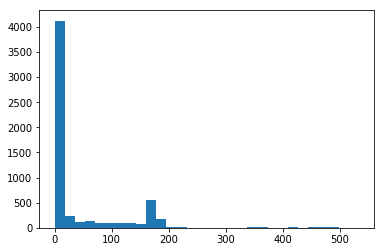

In [510]:
#summary of data on missing street signs

print(db[(db['complaint_type']=='Street Sign - Missing')&(db['response_time_days']>160)].res_desc.value_counts(),
db[(db['complaint_type']=='Street Sign - Missing')&(db['response_time_days']>160)].descriptor.value_counts(),
db[(db['complaint_type']=='Street Sign - Missing')&(db['response_time_days']>160)]['community_board'].value_counts(),
db[(db['complaint_type']=='Street Sign - Missing')&(db['response_time_days']<160)].res_desc.value_counts(),
db[(db['complaint_type']=='Street Sign - Missing')&(db['response_time_days']<160)].descriptor.value_counts(),
db[(db['complaint_type']=='Street Sign - Missing')&(db['response_time_days']<160)]['community_board'].value_counts())


ax = plt.hist(db[db['complaint_type']=='Street Sign - Missing'].response_time_days, bins = 30)
ax.set(xlabel='Num Days to Close', ylabel='Num Complaints')
plt.title("Missing Street Signs", fontsize=20)
plt.show()
ax

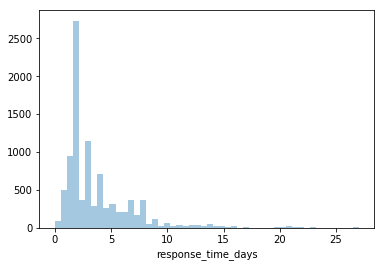

In [511]:
#analyzing electronics waste complaints that took less thanh 1000 hours, represented as days (~ <45)
sns.distplot(db[(db['complaint_type']=='Electronics Waste')&(db['response_time_hours']<1000)].response_time_days, kde=False)

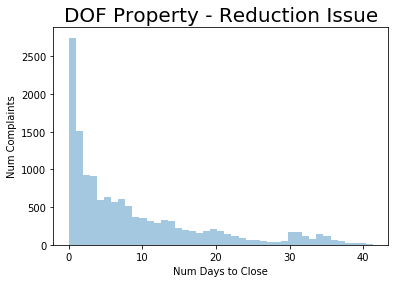

In [512]:
#begin analysis of complaint: 'DOF Property - Reduction Issue'

ax = sns.distplot(
    db[(db['complaint_type']=='DOF Property - Reduction Issue')&
       (db['response_time_hours']<1000)]['response_time_days'], kde=False)
ax.set(xlabel='Num Days to Close', ylabel='Num Complaints')
plt.title("DOF Property - Reduction Issue", fontsize=20)
plt.show()



In [513]:
# 'DOF Property - Reduction Issue' resolution summary
print(
    db[(db['complaint_type']=='DOF Property - Reduction Issue')&
    (db['response_time_hours']<1000)&
    (db['response_time_hours']>700)]['resolution_description'].value_counts(),
    db[(db['complaint_type']=='DOF Property - Reduction Issue')&
       (db['response_time_hours']<700)]['resolution_description'].value_counts())

see notes.                                                                            996
the department of finance determined that you are not eligible for this reduction.    11 
the department of finance granted this reduction.                                     5  
Name: resolution_description, dtype: int64 see notes.                                                                                                                                  12753
the department of finance granted this reduction.                                                                                           88   
the department of finance determined that you are not eligible for this reduction.                                                          78   
the department of finance was unable to resolve the issue as it requires additional information.                                            27   
the department of finance did not receive an application for this reduction. they mailed you a blank ap

fixed              3640
no_action_taken    334 
did_not_observe    239 
wrong_agency       11  
string             11  
Name: res_desc, dtype: int64 Branch or Limb Has Fallen Down    1385
Branch Cracked and Will Fall      974 
Tree Alive - in Poor Condition    777 
Entire Tree Has Fallen Down       658 
Tree Leaning/Uprooted             371 
Tree Trunk Split                  70  
Name: descriptor, dtype: int64 03 STATEN ISLAND        251
02 STATEN ISLAND        242
01 STATEN ISLAND        227
01 BROOKLYN             201
08 QUEENS               189
07 QUEENS               185
18 BROOKLYN             174
01 QUEENS               173
12 BROOKLYN             157
05 QUEENS               147
13 QUEENS               136
11 QUEENS               123
10 BRONX                110
12 BRONX                102
06 QUEENS               100
12 QUEENS               99 
11 BROOKLYN             88 
11 BRONX                84 
08 BRONX                81 
02 BROOKLYN             81 
06 BROOKLYN             79

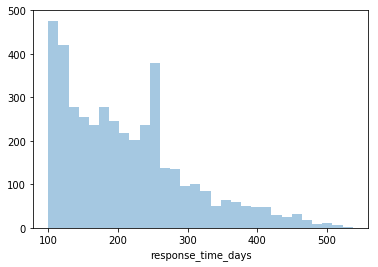

In [514]:
#damaged tree summary

print(db[(db['complaint_type']=='Damaged Tree')&(db['response_time_days']>100)].res_desc.value_counts(),
      db[(db['complaint_type']=='Damaged Tree')&(db['response_time_days']>100)].descriptor.value_counts(),
      db[(db['complaint_type']=='Damaged Tree')&(db['response_time_days']>100)]['community_board'].value_counts(),
      db[(db['complaint_type']=='Damaged Tree')&(db['response_time_days']<100)].res_desc.value_counts(),
      db[(db['complaint_type']=='Damaged Tree')&(db['response_time_days']<100)].descriptor.value_counts(),
      db[(db['complaint_type']=='Damaged Tree')&(db['response_time_days']<100)]['community_board'].value_counts())
      
sns.distplot(db[(db['complaint_type']=='Damaged Tree')&(db['response_time_days']>100)].response_time_days, kde=False)

In [515]:
#analyze complaint responses and resolution times regarding rodents

rats = data_orig[data_orig['complaint_type']=='Rodent']
print(rats['response_time_hours'].median(),
      dist_df_spread[dist_df_spread['Type'] == 'Rodent']['Time'].mean())
rats['response_time_days'] = [i.total_seconds()/86400.0 for i in rats['response_time']]


#percent of rodent complaints that are solved in negative time
len(rats[rats.response_time_hours<=0])/len(rats)



96.0 197.28772595005788


/Users/bwitte/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0.23713461066077132

In [516]:
rats_grouped = rats.groupby('response_time_days')
rats_grouped = rats_grouped.agency.aggregate('count')
rats_grouped.to_csv('2018_rat_times.csv')

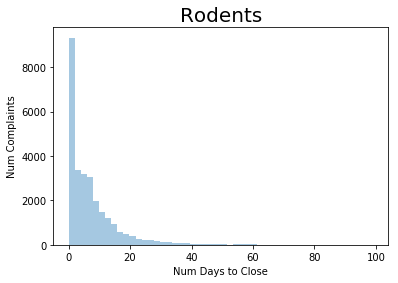

In [517]:
rodents = sns.distplot(rats[(rats.response_time_days>-100)&(rats.response_time_days<100)].response_time_days, kde=False)
rodents.set(xlabel='Num Days to Close', ylabel='Num Complaints')
plt.title("Rodents", fontsize=20)
plt.show()

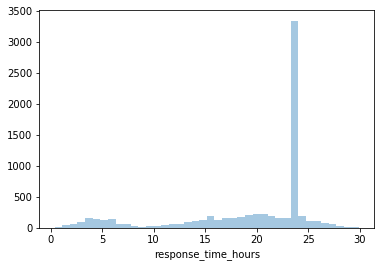

In [518]:
#analyzing lead kit responses in less than 30 hours - 
# - it appears an automatic message is sent out exactly 24 hours after the complaint is made
sns.distplot(db[(db['complaint_type']=='Lead')
               &(db.response_time_hours<30)].response_time_hours, kde=False)

In [519]:
signs = db[db['complaint_type']=='Street Sign - Missing']
signs_grouped = signs.groupby('response_time_days')
signs_grouped = signs_grouped.agency.aggregate('count')
signs_grouped.to_csv('2018_signs_times.csv')

In [520]:
db[(db.res_desc == 'ambiguous')&(db.agency == 'DOT')&(db['complaint_type']=='Street Light Condition')]['resolution_description'].value_counts()

service request status for this request is available on the department of transportationâs website. please click the âlearn moreâ link below.    69737
service request status for this request is available on the department of transportation's website. please click the "learn more" link below.          5966 
Name: resolution_description, dtype: int64

In [521]:
#which agencies have the greatest number of ambiguous resolutions?
db[db.res_desc == 'ambiguous'].agency.value_counts()

DOT      135985
NYPD     40728 
DOF      39674 
HPD      37303 
DOB      20960 
DEP      3470  
TLC      586   
DCA      48    
DOHMH    3     
Name: agency, dtype: int64

In [522]:
#total DOT ambiguous resolutions as a percentage of all DOT resolutions
len(db[(db.agency=='DOT')&(db.res_desc == "ambiguous")])/len(db[db.agency == 'DOT'])

0.4650331714657

In [523]:
len(db[(db.res_desc == 'ambiguous')&(db.agency == 'DOT')&(db['complaint_type']=='Street Light Condition')])

75703

In [524]:
db[(db.res_desc == 'ambiguous')&(db.agency == 'DOT')&(db['complaint_type']=='Street Light Condition')].descriptor.value_counts()

Street Light Out                     54728
Lamppost Base Door/Cover Open        2661 
Fixture/Luminaire Out Of Position    2219 
Street Light Cycling                 2182 
Fixture/Luminaire Door Open          1370 
Multiple Street Lights Out           1326 
Street Light Lamp Dim                1192 
Photocell (PEC) Missing              916  
Fixture/Luminaire Hanging            862  
Lamppost Damaged                     840  
Street Light Dayburning              784  
Lamppost Wire Exposed                757  
Flood Light Lamp Out                 650  
Lamppost Knocked Down                632  
Lamppost Leaning                     597  
Traffic Signal Light                 531  
Fixture/Luminaire Damaged            371  
Street Light Lamp Missing            364  
Lamppost Base Door/Cover Damaged     363  
Foreign Attachment On Lamppost       295  
Flood Light Lamp Cycling             235  
Lamppost Missing                     233  
Lamppost Base Door/Cover Missing     209  
Multiple St

In [525]:
###################################  Top Agency Breakdown  ##############################################################

In [526]:
agency_list_final = ['NYPD','HPD','DSNY','DOT','DEP','DOB','DPR','DOF','DOHMH','TLC']
pattern = '|'.join(agency_list_final)

agencies = db[db.agency.str.contains(pattern)==True]
agencies_grouped = agencies.groupby(['agency','res_desc'])
agencies_grouped = agencies_grouped.descriptor.aggregate(['count']).reset_index()
agencies_grouped.loc[agencies_grouped['res_desc'].str.contains('string'), 'res_desc'] = 'other'
agency_totals = agencies_grouped.groupby('agency')
agency_totals = agency_totals['count'].aggregate('sum').reset_index().rename(columns = {'count': 'total'})
agencies_joined = agencies_grouped.merge(agency_totals, on = 'agency')
agencies_joined['percent_per_agency'] = round(agencies_joined['count']/agencies_joined.total,2)
agencies_joined
agencies_joined.to_csv('2018_agencies_rates.csv')

In [527]:
#breakdown of noise complaints by ones that NYPD responds to vs. ones that DEP responds to
print(
    len(db[(db.agency=='NYPD')&(db['complaint_type'].str.lower().str.contains('noise'))]),
    len(db[(db.agency=='DEP')&(db['complaint_type'].str.lower().str.contains('noise'))])
)

375664 60556


In [528]:
#breakdown of what % of all noise complaints are residential vs. construction noise
noise_total = len(db[db['complaint_type'].str.contains('Noise')])

print(
    round(len(db[db['complaint_type'].str.contains('Residential')]['complaint_type'])/noise_total,3),
    round(len(db[(db.agency=='DEP')&(db['complaint_type'].str.contains('Noise'))])/noise_total,3)
    )

0.498 0.138


In [529]:
#breakdown of what % of DEP complaints are noise-related.
len(db[(db.agency=='DEP')&(db['complaint_type']=='Noise')])/len(db[db.agency=='DEP'])

0.30057080458629076

In [530]:
################################################# Data Requests for 311 Hearing ##############################################

In [531]:
# Top 10 complaints (service request categories),

top_complaints = db['complaint_type'].value_counts().to_frame().reset_index()
top_complaints = top_complaints.rename(columns = {'index': 'complaint_type', 'complaint_type': 'count'})
top_complaints.complaint_type = top_complaints.complaint_type.str.lower()


top_complaints.loc[top_complaints['complaint_type'].str.contains('noise'), 'complaint_type'] = 'all noise'
top_complaints = top_complaints.groupby('complaint_type')
top_complaints = top_complaints.aggregate('sum').sort_values(by='count', ascending=False).reset_index()
top_complaints[:10].to_csv('2018_top_complaints.csv')

In [532]:
# top 10 responding agencies,

top_agencies = db.agency.value_counts().to_frame().reset_index().rename(columns= {'index': 'agency', 'agency': 'number_complaints'})
top_agencies.head()
top_agencies[:10].to_csv('2018_top_agencies.csv')

In [533]:
# Longest response time average by agency and complaint type? 


longest = db[db.response_time_days >0]
longest_grouped = longest.groupby(['agency','complaint_type'])
longest_grouped = longest_grouped.response_time_days.aggregate(['mean', 'count', 'std']).sort_values(by='mean', ascending=False).reset_index()
longest_grouped = longest_grouped[longest_grouped['count']>1000]
longest_grouped = longest_grouped.rename(columns = {'mean': 'mean_days'})
longest_grouped.to_csv('2018_longest_response_time.csv')

In [534]:
# Shortest (not negative) response time average by agency and complaint type?

no_neg = db[db.response_time_days >0]
no_neg_agency = no_neg.groupby(['agency','complaint_type'])
df_no_negs = no_neg_agency.response_time_minutes.aggregate(['mean', 'count', 'std']).sort_values(by='mean').reset_index()
df_no_negs = df_no_negs[df_no_negs['count']>1000]
df_no_negs = df_no_negs.rename(columns = {'mean': 'mean_minutes'})

df_no_negs.to_csv('2018_shortest_response_time.csv')

In [535]:
# DSNY Snow Storm data – responsiveness, closing complaints, geography: look at dates from NOV 2018 Snow Storm and JAN / FEB 2018 Snow Storm; % forwarded or not forwarded that should be forwarded

snow = db[(db.agency=='DSNY')&(db['complaint_type']=='Snow')]
tmp = pd.to_datetime(snow['created_date'])
snow['year'] = tmp.dt.year
snow['month'] = tmp.dt.month
snow['day'] = tmp.dt.day



snow_grouped = snow.groupby('community_board')
snow_grouped = snow_grouped.response_time_days.aggregate(['count', 'mean', 'std']).reset_index()
snow_grouped = snow_grouped[~snow_grouped['community_board'].str.contains("Unspecified")]

snow_borough = snow.groupby('borough')
snow_borough = snow_borough.response_time_days.aggregate(['count', 'mean', 'std']).reset_index()


#define function to reverse order of community board so that borough comes first
def reverseWords(input): 
      
    # split words of string separated by space 
    inputWords = input.split(" ") 
  
    # reverse list of words 
    # suppose we have list of elements list = [1,2,3,4],  
    # list[0]=1, list[1]=2 and index -1 represents 
    # the last element list[-1]=4 ( equivalent to list[3]=4 ) 
    # So, inputWords[-1::-1] here we have three arguments 
    # first is -1 that means start from last element 
    # second argument is empty that means move to end of list 
    # third arguments is difference of steps 
    inputWords=inputWords[-1::-1] 
  
    # now join words with space 
    output = ' '.join(inputWords) 
      
    return output

snow_grouped['community_board'] = [reverseWords(x) for x in snow_grouped['community_board']]
snow_grouped=snow_grouped.sort_values(by='community_board')

/Users/bwitte/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/bwitte/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/bwitte/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

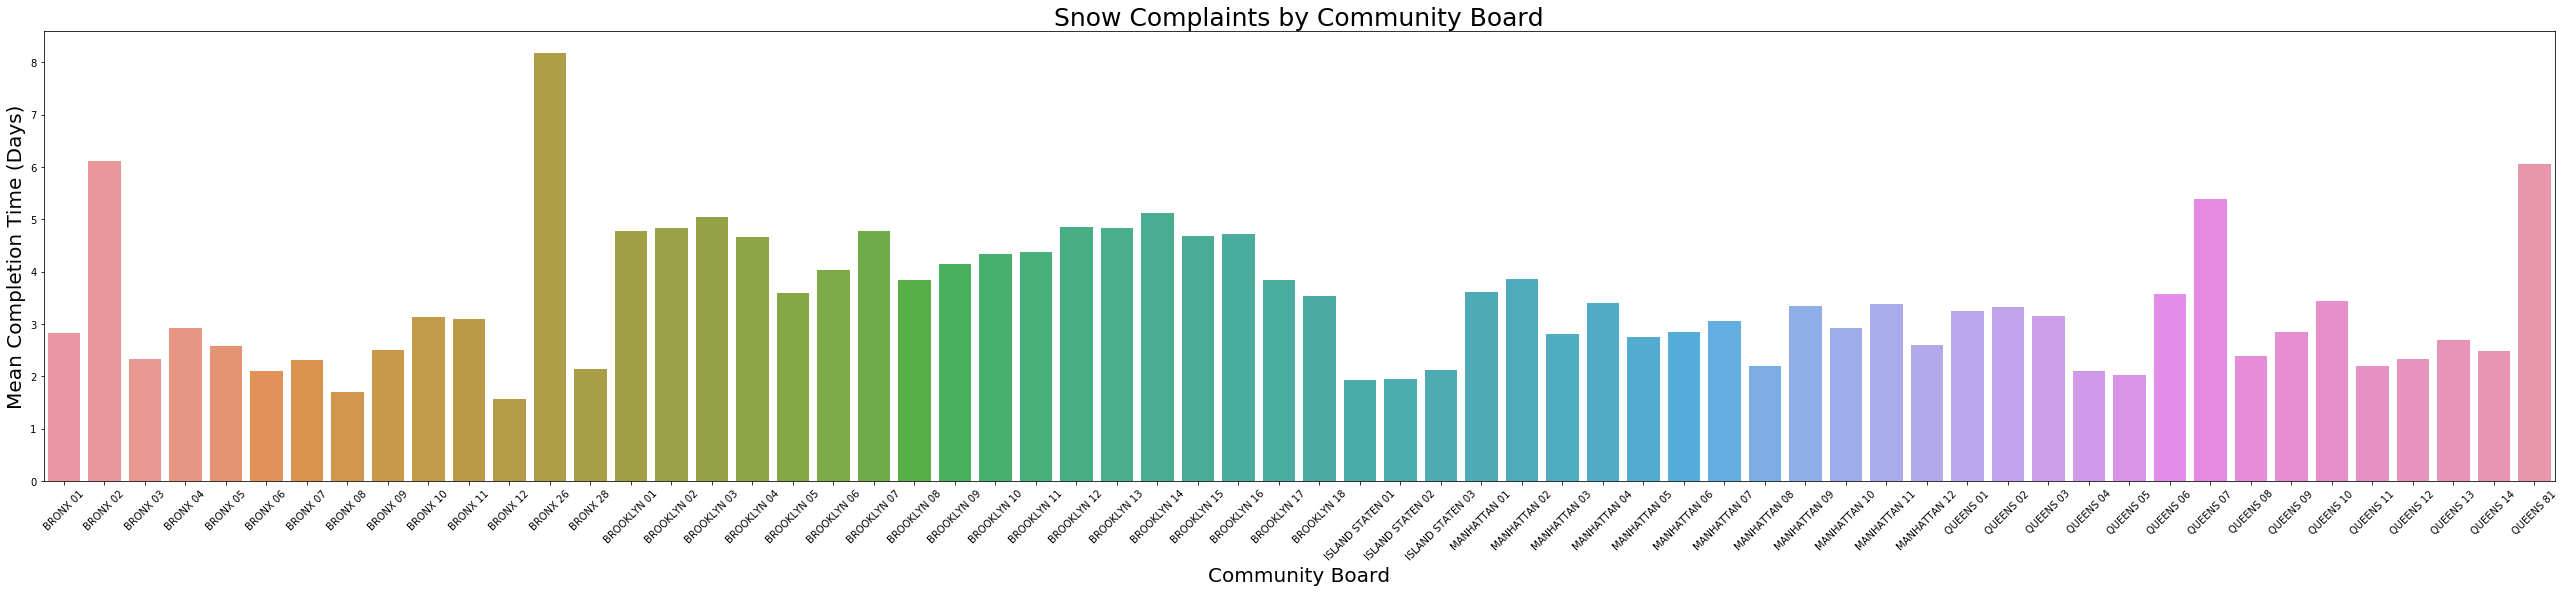

In [536]:
#snow complaints by community board

x= 'community_board'
y= 'mean'



ax = sns.barplot(x, y, data=snow_grouped)
ax.set_title('Snow Complaints by Community Board', fontsize=25)
ax.set_xlabel("Community Board",fontsize=20)
ax.set_ylabel("Mean Completion Time (Days)",fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.gcf().set_size_inches(45, 8.27)
plt.show()

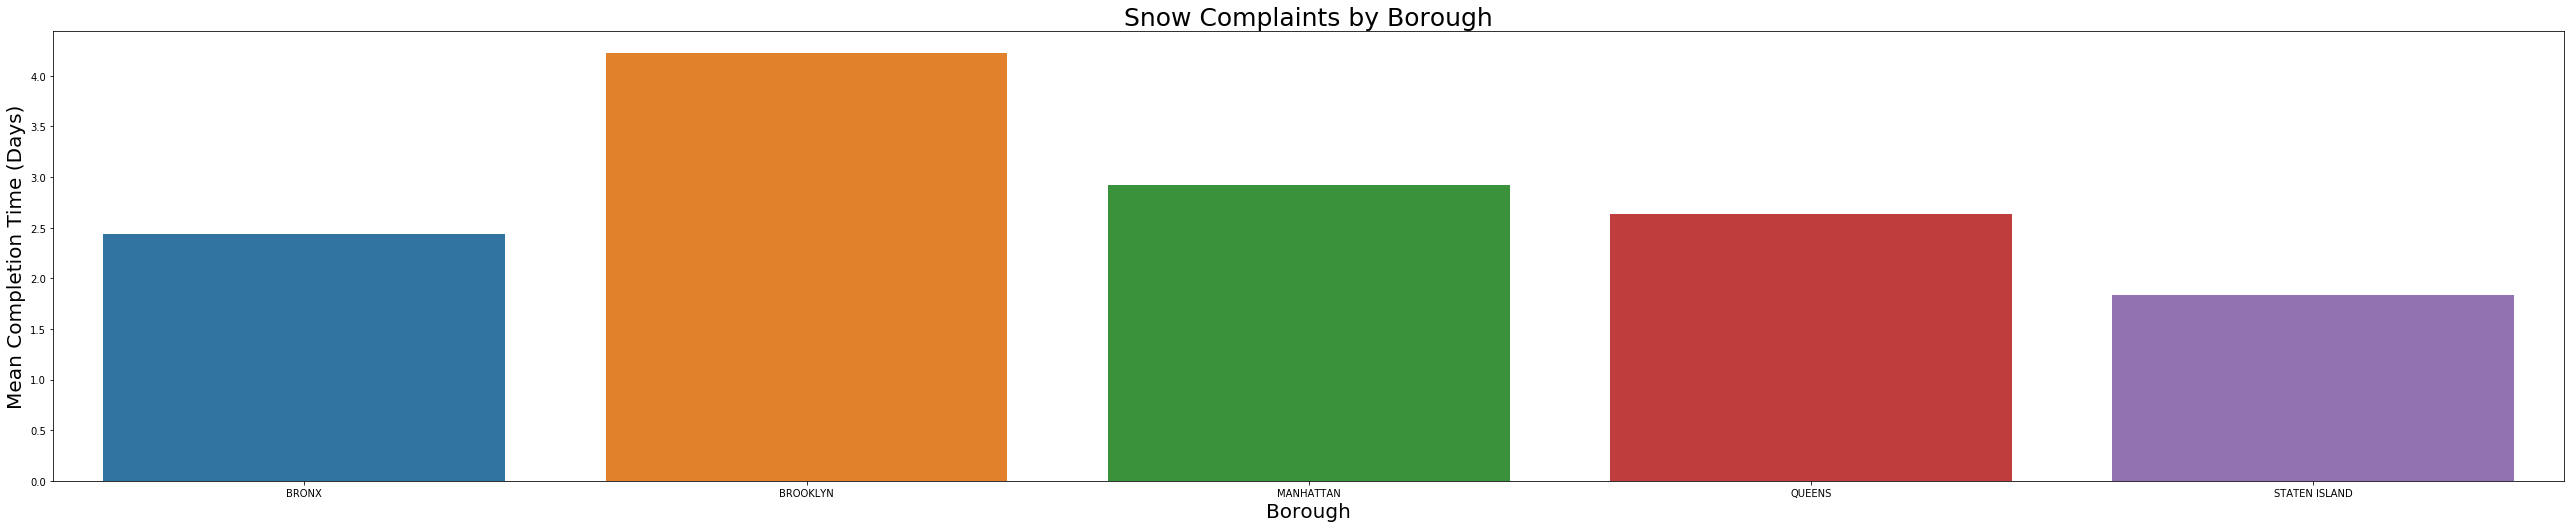

In [537]:
#snow complaints by borough


x= 'borough'
y= 'mean'



ax = sns.barplot(x, y, data=snow_borough)
ax.set_title('Snow Complaints by Borough', fontsize=25)
ax.set_xlabel("Borough",fontsize=20)
ax.set_ylabel("Mean Completion Time (Days)",fontsize=20)
plt.gcf().set_size_inches(45, 8.27)
plt.show()

min days:  0.0 
 max days:  513.13 
 mean:  2.88 
 median:  2.3 
 iqr:  2.47 
 % unobserved:  0.15


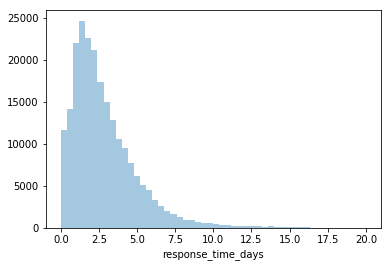

In [538]:
# HPD Heat and Hot Water Complaints – response window? What percentage are unobserved?

heat_water =  db[db['complaint_type']== 'HEAT/HOT WATER']
heat_water = heat_water[heat_water.response_time_days >0]
print(
    'min days: ',round(heat_water.response_time_days.min(),2),'\n',
    'max days: ',round(heat_water.response_time_days.max(),2),'\n',
    'mean: ',round(heat_water.response_time_days.mean(),2),'\n',
    'median: ',round(heat_water.response_time_days.median(),2),'\n',
    'iqr: ',round(iqr(heat_water.response_time_days),2),'\n',
    '% unobserved: ', round(len(heat_water[heat_water.res_desc == 'did_not_observe'])/len(heat_water),2)
)

sns.distplot(heat_water[heat_water.response_time_days<20].response_time_days, kde=False)

In [539]:
# HPD What types of complaints are consistently (if any) going unobserved?

df_hpd = db[db.agency =='HPD']
grouped_hpd = df_hpd.groupby(['complaint_type','res_desc'])
grouped_hpd = grouped_hpd.agency.aggregate('count').to_frame().reset_index()
grouped_hpd

pivot_hpd = grouped_hpd.pivot_table(index='complaint_type',columns='res_desc',aggfunc=sum)
pivot_hpd.fillna(0,inplace=True)
pivot_hpd.columns = pivot_hpd.columns.droplevel()
pivot_hpd.columns.name = None
pivot_hpd.reset_index(inplace=True)
#pivot_hpd = pivot_hpd.drop(pivot_hpd.columns[[7,8,9]], axis=1)
pivot_hpd['total'] = pivot_hpd.sum(axis=1)
pivot_hpd['unobserved_rate'] = round(pivot_hpd.did_not_observe/pivot_hpd.total,2)
pivot_hpd = pivot_hpd.sort_values(by= 'unobserved_rate', ascending = False)
pivot_hpd.to_csv('hpd_unobserved_rate.csv')

In [540]:
# HPD Lead Complaints – response window? Resolution?
tmp = db[(db.agency == "HPD")&(db.descriptor.str.contains('Lead')==True)]
tmp.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,cross_street_1,cross_street_2,intersection_street_1,intersection_street_2,address_type,city,landmark,facility_type,status,due_date,resolution_description,resolution_action_updated_date,community_board,bbl,borough,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_facility_name,park_borough,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location,response_time,response_time_days,response_time_hours,response_time_minutes,response_time_seconds,under_120,res_desc
292996,38398462,2018-02-06 14:04:49,2018-02-12 11:59:17,HPD,Department of Housing Preservation and Development,HPD Literature Request,New Lead Law Rights and Requirements,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Closed,2018-02-19T11:58:45.000,"the literature has been mailed. if it has not been received, please request it again from 311.",2018-02-12T11:59:17.000,0 Unspecified,NaN,Unspecified,NaN,NaN,PHONE,Unspecified,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 days 21:54:28,5.912824,141.907778,8514.466667,510868.0,0,fixed
683409,38849728,2018-04-03 10:43:43,2018-04-04 10:46:25,HPD,Department of Housing Preservation and Development,HPD Literature Request,New Lead Law Rights and Requirements,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Closed,2018-04-04T10:43:43.000,"the literature will be emailed within 24 hours. if it is not received, please call 311 and submit a new request.",2018-04-03T10:45:42.000,0 Unspecified,NaN,Unspecified,NaN,NaN,PHONE,Unspecified,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 days 00:02:42,1.001875,24.045000,1442.700000,86562.0,0,ongoing
783234,38966357,2018-04-17 10:36:12,2018-04-18 10:39:28,HPD,Department of Housing Preservation and Development,HPD Literature Request,New Lead Law Rights and Requirements,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Closed,2018-04-18T10:36:12.000,"the literature will be emailed within 24 hours. if it is not received, please call 311 and submit a new request.",2018-04-17T10:38:47.000,0 Unspecified,NaN,Unspecified,NaN,NaN,PHONE,Unspecified,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 days 00:03:16,1.002269,24.054444,1443.266667,86596.0,0,ongoing
805006,38990006,2018-04-20 07:02:08,2018-04-23 11:37:58,HPD,Department of Housing Preservation and Development,HPD Literature Request,New Lead Law Rights and Requirements,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Closed,2018-04-30T11:37:54.000,"the literature has been mailed. if it has not been received, please request it again from 311.",2018-04-23T11:37:58.000,0 Unspecified,NaN,Unspecified,NaN,NaN,PHONE,Unspecified,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3 days 04:35:50,3.191551,76.597222,4595.833333,275750.0,0,fixed
998958,39202911,2018-05-16 18:01:05,2018-05-17 18:04:09,HPD,Department of Housing Preservation and Development,HPD Literature Request,New Lead Law Rights and Requirements,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Closed,2018-05-17T18:01:05.000,"the literature will be emailed within 24 hours. if it is not received, please call 311 and submit a new request.",2018-05-16T18:03:35.000,0 Unspecified,NaN,Unspecified,NaN,NaN,PHONE,Unspecified,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 days 00:03:04,1.002130,24.051111,1443.066667,86584.0,0,ongoing


In [541]:
# DEP Lead Kit Request – response window? Resolutions? Follow-up with Kit results?

lead.res_desc.value_counts()

fixed              8836
no_action_taken    3   
did_not_observe    2   
Name: res_desc, dtype: int64

In [542]:
# DOT Pothole Complaints – response window? Resolution? How many pothole complaints get sent to DEP (can we assume these are in fact sinkholes)? What is the DEP Resolution?

db[db['complaint_type'] =='Street Condition']['descriptor'].value_counts()

db[db.descriptor == 'Pothole']['resolution_description'].value_counts()

print(
    'min days: ',round(db[db.descriptor == 'Pothole'].response_time_days.min(),2),'\n',
    'max days: ',round(db[db.descriptor == 'Pothole'].response_time_days.max(),2),'\n',
    'mean: ',round(db[db.descriptor == 'Pothole'].response_time_days.mean(),2),'\n',
    'median: ',round(db[db.descriptor == 'Pothole'].response_time_days.median(),2),'\n',
    'iqr: ',round(iqr(db[db.descriptor == 'Pothole'].response_time_days),2),'\n',
    '% unobserved: ', round((len(db[(db.descriptor == 'Pothole')&(db.res_desc == 'did_not_observe')])*100)/len(db[db.descriptor == 'Pothole']),2)
)

min days:  -0.35 
 max days:  593.53 
 mean:  4.05 
 median:  1.29 
 iqr:  4.4 
 % unobserved:  9.88


In [543]:
#calculate how much of a the data set is covered by the classification system
db.res_desc.value_counts()

len(db[(db.res_desc != 'string')])/len(db)

0.9977277049187039

In [544]:
# NYPD Noise Complaints by Borough and Community Board

noise_nypd = db[(db.agency == "NYPD")&(db['complaint_type'].str.contains('Noise'))]
noise_board = noise_nypd.groupby('community_board')
noise_board = noise_board.response_time_hours.aggregate(['count', 'mean', 'std']).reset_index()
noise_boro = noise_nypd.groupby('borough')
noise_boro = noise_boro.response_time_hours.aggregate(['count', 'mean', 'std']).reset_index()


noise_board = noise_board[~noise_board['community_board'].str.contains("Unspecified")]
noise_boro = noise_boro[~noise_boro['borough'].str.contains("Unspecified")]


noise_board['community_board'] = [reverseWords(x) for x in noise_board['community_board']]
noise_board=noise_board.sort_values(by='community_board')

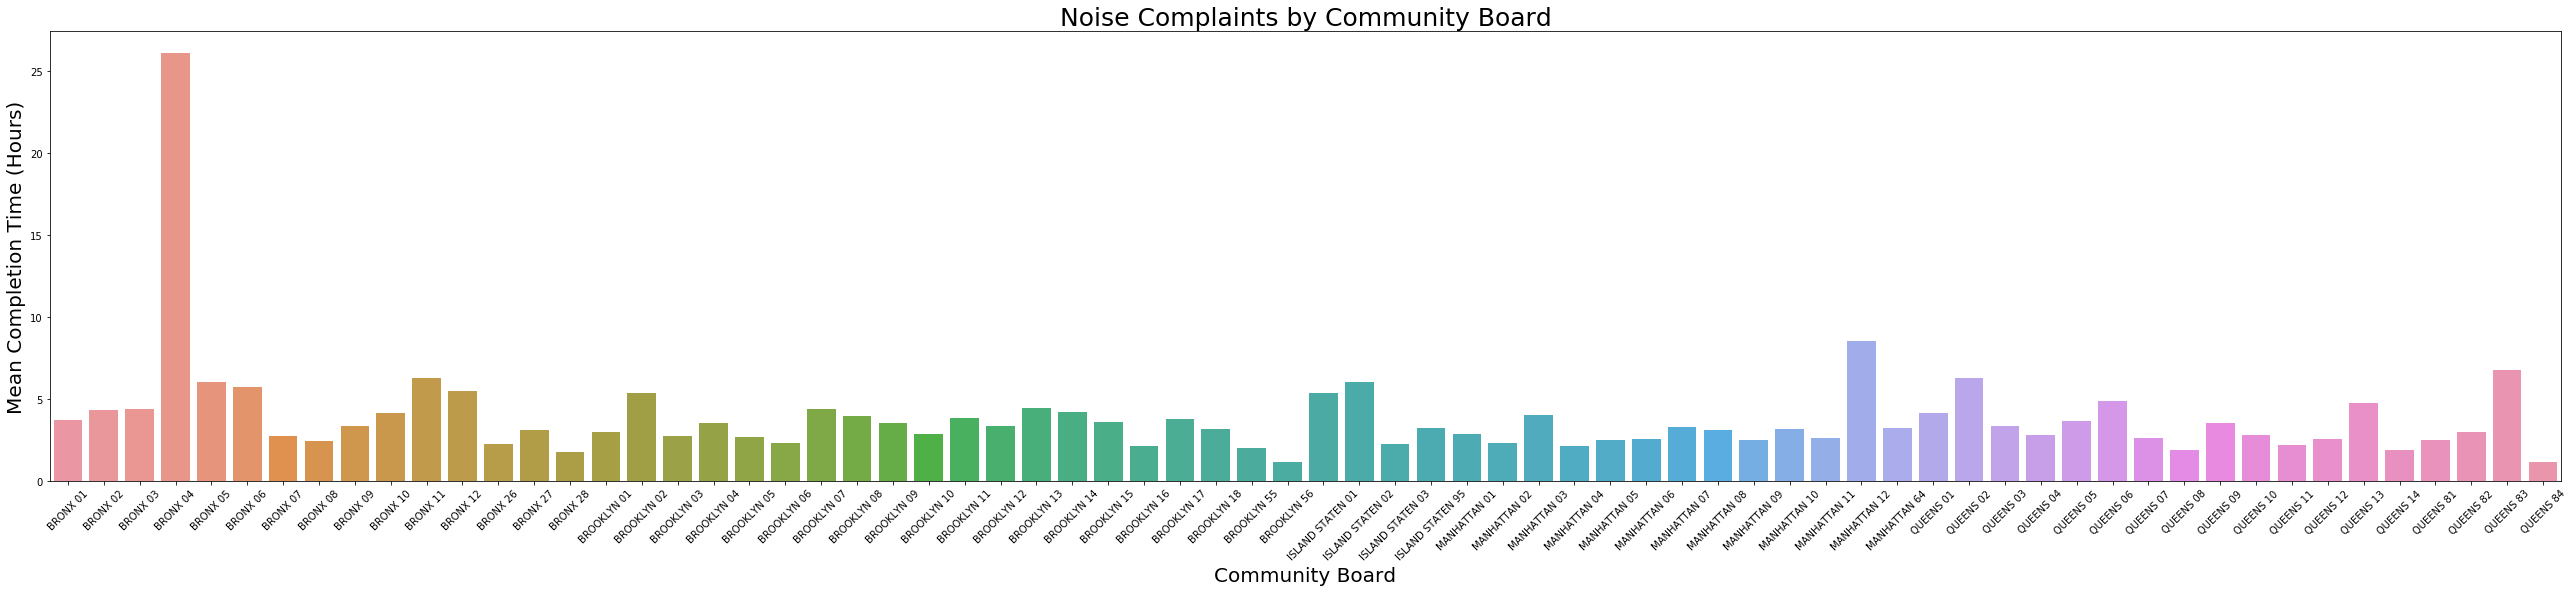

In [545]:
x= 'community_board'
y= 'mean'



ax = sns.barplot(x, y, data=noise_board)
ax.set_title('Noise Complaints by Community Board', fontsize=25)
ax.set_xlabel("Community Board",fontsize=20)
ax.set_ylabel("Mean Completion Time (Hours)",fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.gcf().set_size_inches(45, 8.27)
plt.show()

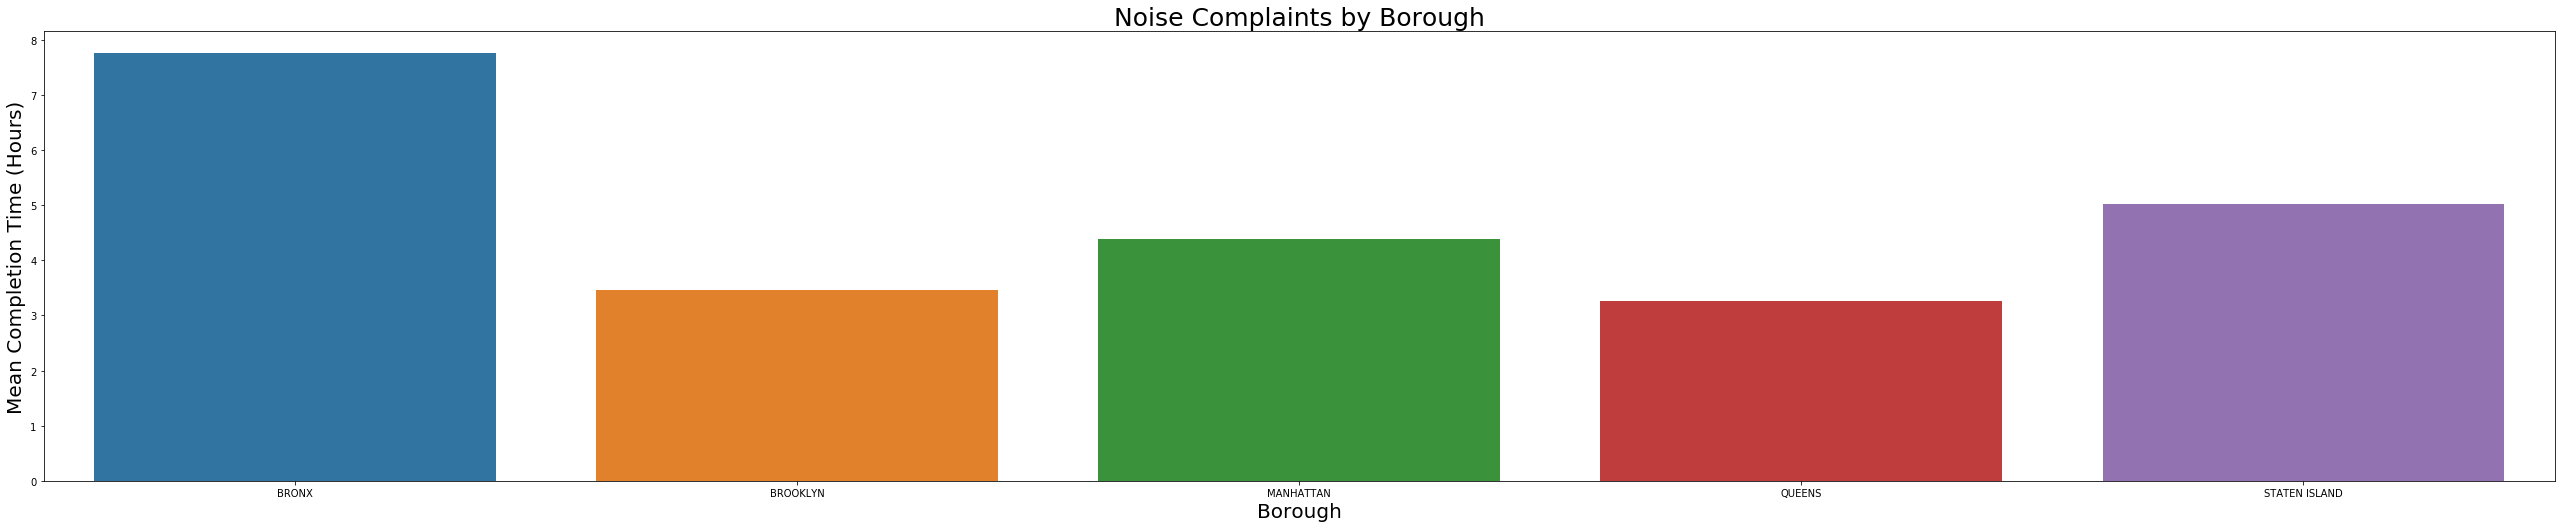

In [546]:
x= 'borough'
y= 'mean'



ax = sns.barplot(x, y, data=noise_boro)
ax.set_title('Noise Complaints by Borough', fontsize=25)
ax.set_xlabel("Borough",fontsize=20)
ax.set_ylabel("Mean Completion Time (Hours)",fontsize=20)
plt.gcf().set_size_inches(45, 8.27)
plt.show()

In [547]:
#median, mean and iqr response times for 04 Bronx in hours
print(
    noise_nypd[noise_nypd['community_board'] == "04 BRONX"].response_time_hours.median(),
    noise_nypd[noise_nypd['community_board'] == "04 BRONX"].response_time_hours.mean(),
    iqr(noise_nypd[noise_nypd['community_board'] == "04 BRONX"].response_time_hours)
)

15.009583333333333 26.13804910350472 27.447430555555556


In [548]:
# check other and unknown for dohmh and tlc, which shot up in 2019 over 2018
pd.set_option('display.max_colwidth', -1)
db[(db.res_desc == "string")&(db.agency == "TLC")].groupby('resolution_description').count()


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,cross_street_1,cross_street_2,intersection_street_1,intersection_street_2,address_type,city,landmark,facility_type,status,due_date,resolution_action_updated_date,community_board,bbl,borough,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_facility_name,park_borough,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location,response_time,response_time_days,response_time_hours,response_time_minutes,response_time_seconds,under_120,res_desc
resolution_description,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
the taxi and limousine commission provided the insurance information requested.,220,220,220,220,220,220,220,220,212,79,78,85,85,121,121,203,212,8,0,220,15,220,220,74,220,211,211,220,220,220,0,10,69,11,10,9,9,211,211,211,220,220,220,220,220,220,220


In [549]:
db.agency.unique()

array(['DOHMH', 'HPD', 'NYPD', 'DEP', 'DSNY', 'DOB', 'DOT', 'DPR', 'DHS',
       'TLC', 'DFTA', 'DOF', 'DCA', 'HRA', 'DOITT', 'DOE', 'EDC', 'NYCEM'],
      dtype=object)